In [1]:
# pip install pmdarima

In [2]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 
import seaborn as sns 
import folium

from math import sqrt
from sklearn.metrics import mean_squared_error
from matplotlib.pylab import rcParams
import itertools

# TIME SERIES
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas import Timestamp
from datetime import datetime

#MODELLING
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
import statsmodels.api as sm

from sklearn.preprocessing import LabelEncoder
# settings
import os
import gc
import warnings
warnings.filterwarnings("ignore")

In [3]:
# 변수 지정
df_cats = pd.read_csv('item_categories.csv')
df_items = pd.read_csv('items.csv')
df_train = pd.read_csv('sales_train.csv')
df_shops = pd.read_csv('shops.csv')
df_test = pd.read_csv('test.csv')
df_sub = pd.read_csv('sample_submission.csv')

## EDA

#### 데이터 불러오기

In [4]:
df_cats.head(3)

item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2

In [5]:
df_items.head(3)

item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   

   item_category_id  
0                40  
1                76  
2                40

In [6]:
df_train.head(3)

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154       999.0           1.0
1  03.01.2013               0       25     2552       899.0           1.0
2  05.01.2013               0       25     2552       899.0          -1.0

In [7]:
df_train.tail(3)

date  date_block_num  shop_id  item_id  item_price  \
2935846  14.10.2015              33       25     7459       349.0   
2935847  22.10.2015              33       25     7440       299.0   
2935848  03.10.2015              33       25     7460       299.0   

         item_cnt_day  
2935846           1.0  
2935847           1.0  
2935848           1.0

In [8]:
df_shops.head(3)

shop_name  shop_id
0  !Якутск Орджоникидзе, 56 фран        0
1  !Якутск ТЦ "Центральный" фран        1
2               Адыгея ТЦ "Мега"        2

In [9]:
df_test.head(3)

ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233

In [10]:
# 데이터는 문제 없이 잘 출력된다는 것을 확인,완.

#### 세부사항 파악

###### item_categories

In [11]:
df_cats.head()

item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4

In [12]:
df_cats.tail()
# 총 84개의 데이터

item_category_name  item_category_id
79                  Служебные                79
80         Служебные - Билеты                80
81    Чистые носители (шпиль)                81
82  Чистые носители (штучные)                82
83           Элементы питания                83

In [13]:
df_cats.isnull().sum()
# null값 없음.

item_category_name    0
item_category_id      0
dtype: int64

In [14]:
df_cats.shape

(84, 2)

In [15]:
df_cats.describe()

item_category_id
count         84.000000
mean          41.500000
std           24.392622
min            0.000000
25%           20.750000
50%           41.500000
75%           62.250000
max           83.000000

In [16]:
df_cats.item_category_name.unique()

array(['PC - Гарнитуры/Наушники', 'Аксессуары - PS2', 'Аксессуары - PS3',
       'Аксессуары - PS4', 'Аксессуары - PSP', 'Аксессуары - PSVita',
       'Аксессуары - XBOX 360', 'Аксессуары - XBOX ONE', 'Билеты (Цифра)',
       'Доставка товара', 'Игровые консоли - PS2',
       'Игровые консоли - PS3', 'Игровые консоли - PS4',
       'Игровые консоли - PSP', 'Игровые консоли - PSVita',
       'Игровые консоли - XBOX 360', 'Игровые консоли - XBOX ONE',
       'Игровые консоли - Прочие', 'Игры - PS2', 'Игры - PS3',
       'Игры - PS4', 'Игры - PSP', 'Игры - PSVita', 'Игры - XBOX 360',
       'Игры - XBOX ONE', 'Игры - Аксессуары для игр',
       'Игры Android - Цифра', 'Игры MAC - Цифра',
       'Игры PC - Дополнительные издания',
       'Игры PC - Коллекционные издания', 'Игры PC - Стандартные издания',
       'Игры PC - Цифра', 'Карты оплаты (Кино, Музыка, Игры)',
       'Карты оплаты - Live!', 'Карты оплаты - Live! (Цифра)',
       'Карты оплаты - PSN', 'Карты оплаты - Windows (Цифра)',

In [17]:
df_cats.item_category_id.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83],
      dtype=int64)

In [18]:
df_cats[df_cats.duplicated() == True]
# 중복값 없음.

Empty DataFrame
Columns: [item_category_name, item_category_id]
Index: []

In [19]:
df_cats.item_category_name.value_counts()

PC - Гарнитуры/Наушники              1
Книги - Художественная литература    1
Подарки - Атрибутика                 1
Музыка - Подарочные издания          1
Музыка - Музыкальное видео           1
                                    ..
Игры Android - Цифра                 1
Игры - Аксессуары для игр            1
Игры - XBOX ONE                      1
Игры - XBOX 360                      1
Элементы питания                     1
Name: item_category_name, Length: 84, dtype: int64

###### items

In [20]:
df_items.head(3)

item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   

   item_category_id  
0                40  
1                76  
2                40

In [21]:
df_items.tail(3)

item_name  item_id  \
22167  Язык запросов 1С:Предприятия 8 (+CD). Хрустале...    22167   
22168                                Яйцо для Little Inu    22168   
22169                      Яйцо дракона (Игра престолов)    22169   

       item_category_id  
22167                49  
22168                62  
22169                69

In [22]:
df_items.shape
# 22170개의 데이터

(22170, 3)

In [23]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [24]:
df_items.isnull().sum()
# nan값 없음.

item_name           0
item_id             0
item_category_id    0
dtype: int64

In [25]:
df_items.describe()

item_id  item_category_id
count  22170.00000      22170.000000
mean   11084.50000         46.290753
std     6400.07207         15.941486
min        0.00000          0.000000
25%     5542.25000         37.000000
50%    11084.50000         40.000000
75%    16626.75000         58.000000
max    22169.00000         83.000000

In [26]:
df_items.item_id.unique()

array([    0,     1,     2, ..., 22167, 22168, 22169], dtype=int64)

In [27]:
df_items.item_category_id.unique()

array([40, 76, 55, 19, 30, 23, 37, 41, 57, 43, 78, 54, 49, 44, 45, 77, 73,
       31, 75, 58, 56, 38, 67, 59, 60, 74, 21, 28, 20, 24, 29, 70, 22, 32,
       62, 25, 72,  4, 63, 27, 18, 26, 64, 15, 68,  0,  2,  5,  1,  3,  6,
       35, 65, 14, 13, 10, 11, 12, 48, 71, 69,  7, 33, 34, 16, 66, 39, 52,
       46, 42, 61,  8, 80,  9, 17, 36, 47, 82, 81, 50, 51, 79, 53, 83],
      dtype=int64)

In [28]:
df_items[df_items.duplicated() == True]
# 중복값 없음!!

Empty DataFrame
Columns: [item_name, item_id, item_category_id]
Index: []

In [29]:
df_items.value_counts()

item_name                                                 item_id  item_category_id
! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D                 0        40                  1
МОРСКОЙ БОЙ                                               14776    40                  1
МОСКВА НИКОГДА НЕ СПИТ                                    14784    40                  1
МОСКВА 2017 э (BD)                                        14783    37                  1
МОСКВА 2017 (регион)                                      14782    40                  1
                                                                                      ..
V/A Lemongrassmusic  Best of Chillout  2CD (digipack)     7389     55                  1
V/A Lemongrassmusic  Best of Chillout  2  2CD (digipack)  7388     55                  1
V/A Lady Lounge (digipack)                                7387     55                  1
V/A Lady Lounge  3 (digipack)                             7386     55                  1
Яйцо дракона (Игра престол

###### sales_train

In [30]:
df_train.head(3)

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154       999.0           1.0
1  03.01.2013               0       25     2552       899.0           1.0
2  05.01.2013               0       25     2552       899.0          -1.0

In [31]:
df_train.tail(3)

date  date_block_num  shop_id  item_id  item_price  \
2935846  14.10.2015              33       25     7459       349.0   
2935847  22.10.2015              33       25     7440       299.0   
2935848  03.10.2015              33       25     7460       299.0   

         item_cnt_day  
2935846           1.0  
2935847           1.0  
2935848           1.0

In [32]:
df_train.shape
# 2935849개의 데이터

(2935849, 6)

In [33]:
df_train.info()
# int와 float 값에서 이상함이 없는지 확인해볼 것.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [34]:
df_train.isnull().sum()
# nan값 없음.

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [35]:
df_train[df_train.duplicated() == True]
# 6 개의 중복값 확인

date  date_block_num  shop_id  item_id  item_price  \
76962    05.01.2013               0       54    20130       149.0   
1435367  23.02.2014              13       50     3423       999.0   
1496766  23.03.2014              14       21     3423       999.0   
1671873  01.05.2014              16       50     3423       999.0   
1866340  12.07.2014              18       25     3423       999.0   
2198566  31.12.2014              23       42    21619       499.0   

         item_cnt_day  
76962             1.0  
1435367           1.0  
1496766           1.0  
1671873           1.0  
1866340           1.0  
2198566           1.0

In [36]:
df_train.date_block_num.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
      dtype=int64)

In [37]:
df_train.shop_id.unique()

array([59, 25, 24, 23, 19, 22, 18, 21, 28, 27, 29, 26,  4,  6,  2,  3,  7,
        0,  1, 16, 15,  8, 10, 14, 13, 12, 53, 31, 30, 32, 35, 56, 54, 47,
       50, 42, 43, 52, 51, 41, 38, 44, 37, 46, 45,  5, 57, 58, 55, 17,  9,
       49, 39, 40, 48, 34, 33, 20, 11, 36], dtype=int64)

In [38]:
df_train.item_price.unique()
# 데이터가 너무 많아 한눈에 안 들어오므로 시각화를 통해 파악.

array([  999.  ,   899.  ,  1709.05, ..., 12198.  ,  4454.  ,  4040.  ])

In [39]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df_train.item_price)
# 이상치 발견

<AxesSubplot:xlabel='item_price'>

In [40]:
df_train[df_train.item_price > 100000]

date  date_block_num  shop_id  item_id  item_price  \
1163158  13.12.2013              11       12     6066    307980.0   

         item_cnt_day  
1163158           1.0

In [41]:
df_train[df_train.item_price <= 0]

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
484683  15.05.2013               4       32     2973        -1.0           1.0

<AxesSubplot:xlabel='item_cnt_day'>

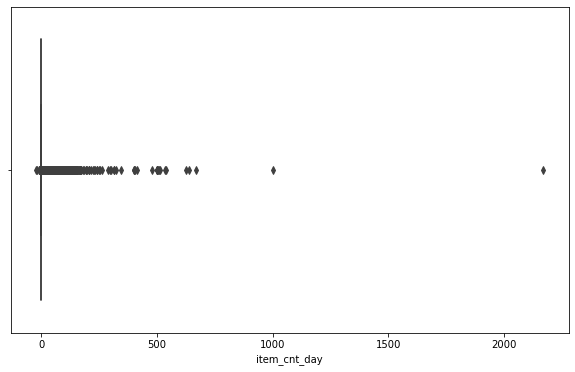

In [42]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df_train.item_cnt_day)
# 이상치가 보이고,
# 음수 값이 보임.

In [43]:
df_train[df_train.item_cnt_day > 900]

date  date_block_num  shop_id  item_id  item_price  \
2326930  15.01.2015              24       12    20949    4.000000   
2909818  28.10.2015              33       12    11373    0.908714   

         item_cnt_day  
2326930        1000.0  
2909818        2169.0

In [44]:
df_train[df_train.item_cnt_day <= 0]
# 음수 값이 7356개 확인

date  date_block_num  shop_id  item_id  item_price  \
2        05.01.2013               0       25     2552       899.0   
148      23.01.2013               0       25     2321       999.0   
175      07.01.2013               0       25     2199      1449.0   
807      02.01.2013               0       25     2330       599.0   
1041     13.01.2013               0       25     5034      1989.0   
...             ...             ...      ...      ...         ...   
2934243  26.10.2015              33       25     3917       449.0   
2934462  18.10.2015              33       25     4896      6398.0   
2935263  05.10.2015              33       25    10039       249.0   
2935643  16.10.2015              33       25     7893      2990.0   
2935779  07.10.2015              33       25     7087       999.0   

         item_cnt_day  
2                -1.0  
148              -1.0  
175              -1.0  
807              -1.0  
1041             -1.0  
...               ...  
2934243          -1.0  
2934462          -1.0  
2935263          -1.0  
2935643          -1.0  
2935779          -1.0  

[7356 rows x 6 columns]

##### 이상치, 음수 값, 중복값 등을 어떻게 처리할지에 대해 고민해볼 것!

###### shops

In [45]:
df_shops.head(3)

shop_name  shop_id
0  !Якутск Орджоникидзе, 56 фран        0
1  !Якутск ТЦ "Центральный" фран        1
2               Адыгея ТЦ "Мега"        2

In [46]:
df_shops.tail(3)

shop_name  shop_id
57  Якутск Орджоникидзе, 56       57
58  Якутск ТЦ "Центральный"       58
59   Ярославль ТЦ "Альтаир"       59

In [47]:
df_shops.shape
# 총 60개의 데이터

(60, 2)

In [48]:
df_shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [49]:
df_shops.isnull().sum()
# nan 값 없음.

shop_name    0
shop_id      0
dtype: int64

In [50]:
df_shops[df_shops.duplicated() == True]
# 중복 값 없습니다.

Empty DataFrame
Columns: [shop_name, shop_id]
Index: []

In [51]:
df_shops.describe()

shop_id
count  60.000000
mean   29.500000
std    17.464249
min     0.000000
25%    14.750000
50%    29.500000
75%    44.250000
max    59.000000

###### test

In [52]:
df_test.head()

ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268

In [53]:
df_test.tail()

ID  shop_id  item_id
214195  214195       45    18454
214196  214196       45    16188
214197  214197       45    15757
214198  214198       45    19648
214199  214199       45      969

In [54]:
df_test.isnull().sum()
# nan값 없음

ID         0
shop_id    0
item_id    0
dtype: int64

In [55]:
df_test[df_test.duplicated() == True]
# 중복값 없음

Empty DataFrame
Columns: [ID, shop_id, item_id]
Index: []

In [56]:
df_test.describe()

ID        shop_id        item_id
count  214200.000000  214200.000000  214200.000000
mean   107099.500000      31.642857   11019.398627
std     61834.358168      17.561933    6252.644590
min         0.000000       2.000000      30.000000
25%     53549.750000      16.000000    5381.500000
50%    107099.500000      34.500000   11203.000000
75%    160649.250000      47.000000   16071.500000
max    214199.000000      59.000000   22167.000000

#### 데이터 시각화(세부사항 확인2)

In [57]:
# 어떤 가게가 매출이 좋은지 확인
m_t_i = pd.merge(df_train,df_items[['item_category_id','item_id']], how='left', on='item_id')
plt.figure(figsize=(16,9))
sns.countplot(m_t_i['shop_id'],palette='viridis')
plt.show()

In [58]:
# 이 그래프를 토대로 매출 좋은 가게들을 뽑아냅니다.

In [59]:
df_shops[df_shops.shop_id.isin([6, 25, 31, 42, 54, 57, 27, 28])]
# count 50000 이상 기업

shop_name  shop_id
6        Воронеж (Плехановская, 13)        6
25              Москва ТРК "Атриум"       25
27   Москва ТЦ "МЕГА Белая Дача II"       27
28  Москва ТЦ "МЕГА Теплый Стан" II       28
31          Москва ТЦ "Семеновский"       31
42           СПб ТК "Невский Центр"       42
54                  Химки ТЦ "Мега"       54
57          Якутск Орджоникидзе, 56       57

In [60]:
# 이제 많이 팔린 item을 찾습니다.

In [61]:
items_count = pd.DataFrame(m_t_i.item_id.value_counts())

In [62]:
items_count.head(3)

item_id
20949    31340
5822      9408
17717     9067

In [63]:
top_items = items_count[items_count.item_id > 5000]

In [64]:
top_items.head()

item_id
20949    31340
5822      9408
17717     9067
2808      7479
4181      6853

In [65]:
plt.figure(figsize=(16,9)) 
sns.barplot(x=top_items.index, y="item_id", data=top_items, palette = "Greens")
# 그래프로 잘 팔린 아이템 확인.

<AxesSubplot:ylabel='item_id'>

In [66]:
top_items.index
# 잘 팔린 아이템 목록

Int64Index([20949,  5822, 17717,  2808,  4181,  7856,  3732,  2308,  4870,
             3734,  1855,  5821, 16787,  6675,  7894,  2445],
           dtype='int64')

In [67]:
df_items[df_items.item_id.isin([20949,  5822, 17717,  2808,  4181,  7856,  3732,  2308,  4870,
             3734,  1855,  5821, 16787,  6675,  7894,  2445])]

item_name  item_id  \
1855                  Battlefield 4 [PC, русская версия]     1855   
2308   Call of Duty: Black Ops II [PС, Jewel, русская...     2308   
2445                       Crysis 3 [PC, русская версия]     2445   
2808              Diablo III [PC, Jewel, русская версия]     2808   
3732          Grand Theft Auto V [PS3, русские субтитры]     3732   
3734     Grand Theft Auto V [Xbox 360, русские субтитры]     3734   
4181   Kaspersky Internet Security Multi-Device Russi...     4181   
4870             Minecraft [Xbox 360, английская версия]     4870   
5821   PlayStation Plus 3-месячная подписка: Карта оп...     5821   
5822   Playstation Store пополнение бумажника: Карта ...     5822   
6675   Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...     6675   
7856   World of Warcraft. Карта оплаты игрового време...     7856   
7894   X360: Геймпад проводной чёрный - Controller BL...     7894   
16787                  Одни из нас [PS3, русская версия]    16787   
17717               Прием денежных средств для 1С-Онлайн    17717   
20949  Фирменный пакет майка 1С Интерес белый (34*42)...    20949   

       item_category_id  
1855                 30  
2308                 30  
2445                 30  
2808                 30  
3732                 19  
3734                 23  
4181                 75  
4870                 23  
5821                 35  
5822                 35  
6675                 12  
7856                 28  
7894                  6  
16787                19  
17717                79  
20949                71

In [68]:
# 이제 잘 팔린 아이템들의 카테고리가 무엇인지 알아봅시다.

In [69]:
items_category_count = pd.DataFrame(m_t_i['item_category_id'].value_counts())

In [70]:
top_items_category = items_category_count[items_category_count['item_category_id']>15000]
top_items_category.sort_index(ascending=True, inplace=True)

In [71]:
top_items_category.head()

item_category_id
2              18461
3              25283
6              18498
19            208219
20             79058

<AxesSubplot:ylabel='item_category_id'>

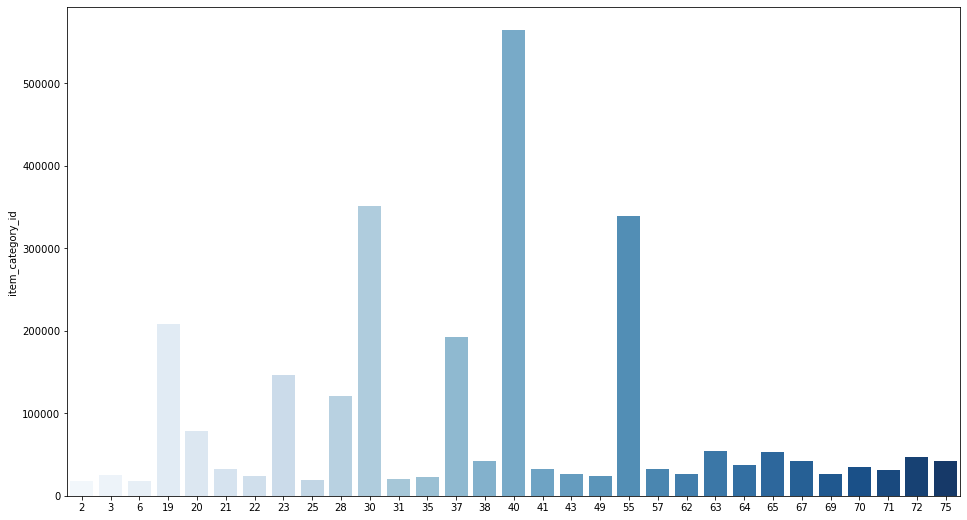

In [72]:
plt.figure(figsize=(16,9)) 
sns.barplot(x=top_items_category.index, y="item_category_id", data=top_items_category, palette = "Blues")

In [73]:
top_items_category.index

Int64Index([ 2,  3,  6, 19, 20, 21, 22, 23, 25, 28, 30, 31, 35, 37, 38, 40, 41,
            43, 49, 55, 57, 62, 63, 64, 65, 67, 69, 70, 71, 72, 75],
           dtype='int64')

In [74]:
df_cats[df_cats.item_category_id.isin([40, 30, 55, 19, 37, 23, 28, 20, 63, 65, 72, 38, 75, 67, 64, 70, 41,
            57, 21, 71, 69, 43, 62,  3, 22, 49, 35, 31, 25,  6,  2])].sort_values(by='item_category_id', ascending=True)

item_category_name  item_category_id
2                           Аксессуары - PS3                 2
3                           Аксессуары - PS4                 3
6                      Аксессуары - XBOX 360                 6
19                                Игры - PS3                19
20                                Игры - PS4                20
21                                Игры - PSP                21
22                             Игры - PSVita                22
23                           Игры - XBOX 360                23
25                 Игры - Аксессуары для игр                25
28          Игры PC - Дополнительные издания                28
30             Игры PC - Стандартные издания                30
31                           Игры PC - Цифра                31
35                        Карты оплаты - PSN                35
37                            Кино - Blu-Ray                37
38                         Кино - Blu-Ray 3D                38
40                                Кино - DVD                40
41                      Кино - Коллекционное                41
43                        Книги - Аудиокниги                43
49         Книги - Методические материалы 1С                49
55       Музыка - CD локального производства                55
57                              Музыка - MP3                57
62          Подарки - Гаджеты, роботы, спорт                62
63                  Подарки - Мягкие игрушки                63
64                 Подарки - Настольные игры                64
65    Подарки - Настольные игры (компактные)                65
67                        Подарки - Развитие                67
69                        Подарки - Сувениры                69
70            Подарки - Сувениры (в навеску)                70
71  Подарки - Сумки, Альбомы, Коврики д/мыши                71
72                         Подарки - Фигурки                72
75              Программы - Для дома и офиса                75

#### 데이터 시각화(도시를 지도에 좌표 찍기)

In [75]:
folium.Map(location=[61.52401,105.318756], zoom_start=3)

In [76]:
df = pd.read_excel('러시아_도시_위도_경도.xlsx')
df.columns = ['구분','위도','경도']
df.set_index('구분', inplace=True)
df.head()

위도          경도
구분                             
!Якутск   62.039691  129.742219
Адыгея    44.822916   40.175446
Балашиха  55.798190   37.967987
Волжский  48.817649   44.770729
Вологда   59.218066   39.897805

In [77]:
Russia_city_map_terrain = folium.Map(location=[61.52401,105.318756], zoom_start=3)

In [78]:
for name, lat, lon in zip(df.index, df.위도, df.경도): 
    print(name,lat,lon)
    folium.Marker([lat,lon], popup=name).add_to(Russia_city_map_terrain)

!Якутск 62.0396912 129.7422192
Адыгея 44.8229155 40.1754463
Балашиха 55.7981904 37.9679867
Волжский 48.8176494 44.7707294
Вологда 59.2180665 39.8978053
Воронеж 51.6683487 39.1919288
Жуковский 55.5974912 38.1132562
Казань 55.7878944 49.1233294
Калуга 54.5135904 36.2636786
Коломна 55.0937517 38.7688618
Красноярск 56.0152834 92.8932476
Курск 51.7482395 36.1947023
Москва 55.755826 37.6172999
Мытищи 55.9248562 37.7552338
Н.Новгород 56.3268684 44.0058793
Новосибирск 54.9832693 82.8963831
Омск 54.9913545 73.3645204
РостовНаДону 47.2357137 39.701505
СПб 59.9310584 30.3609096
Самара 53.203772 50.1606382
Сергиев 56.3151766 38.136706
Сургут 61.2545849 73.3961699
Томск 56.4884295 84.9480469
Тюмень 57.1553394 65.5618637
Уфа 54.734791 55.9578555
Химки 55.8940553 37.4439487
Ярославль 57.6260744 39.8844709


In [79]:
Russia_city_map_terrain

#### Arima preprocessing

In [80]:
# 중복값 확인 후 중복값 제거 
df_train.drop_duplicates(inplace=True)

In [81]:
# 이상치 확인후 적절한 수치로 조정 & 음수값이 있기 때문에 제거 (가격과 수량은 음수가 될수 없음 )
df_train = df_train[(df_train.item_price < 100000)&(df_train.item_price >= 0)]
df_train = df_train[(df_train.item_cnt_day >= 0)&(df_train.item_cnt_day < 1000)]

In [82]:
df_shops

shop_name  shop_id
0                     !Якутск Орджоникидзе, 56 фран        0
1                     !Якутск ТЦ "Центральный" фран        1
2                                  Адыгея ТЦ "Мега"        2
3                    Балашиха ТРК "Октябрь-Киномир"        3
4                          Волжский ТЦ "Волга Молл"        4
5                            Вологда ТРЦ "Мармелад"        5
6                        Воронеж (Плехановская, 13)        6
7                            Воронеж ТРЦ "Максимир"        7
8                      Воронеж ТРЦ Сити-Парк "Град"        8
9                                 Выездная Торговля        9
10                       Жуковский ул. Чкалова 39м?       10
11                       Жуковский ул. Чкалова 39м²       11
12                              Интернет-магазин ЧС       12
13                              Казань ТЦ "Бехетле"       13
14                          Казань ТЦ "ПаркХаус" II       14
15                             Калуга ТРЦ "XXI век"       15
16                                 Коломна ТЦ "Рио"       16
17                    Красноярск ТЦ "Взлетка Плаза"       17
18                             Красноярск ТЦ "Июнь"       18
19                            Курск ТЦ "Пушкинский"       19
20                              Москва "Распродажа"       20
21                           Москва МТРЦ "Афи Молл"       21
22                               Москва Магазин С21       22
23                 Москва ТК "Буденовский" (пав.А2)       23
24                 Москва ТК "Буденовский" (пав.К7)       24
25                              Москва ТРК "Атриум"       25
26                      Москва ТЦ "Ареал" (Беляево)       26
27                   Москва ТЦ "МЕГА Белая Дача II"       27
28                  Москва ТЦ "МЕГА Теплый Стан" II       28
29               Москва ТЦ "Новый век" (Новокосино)       29
30                           Москва ТЦ "Перловский"       30
31                          Москва ТЦ "Семеновский"       31
32                       Москва ТЦ "Серебряный Дом"       32
33                                Мытищи ТРК "XL-3"       33
34                             Н.Новгород ТРЦ "РИО"       34
35                      Н.Новгород ТРЦ "Фантастика"       35
36            Новосибирск ТРЦ "Галерея Новосибирск"       36
37                            Новосибирск ТЦ "Мега"       37
38                                   Омск ТЦ "Мега"       38
39            РостовНаДону ТРК "Мегацентр Горизонт"       39
40  РостовНаДону ТРК "Мегацентр Горизонт" Островной       40
41                           РостовНаДону ТЦ "Мега"       41
42                           СПб ТК "Невский Центр"       42
43                                  СПб ТК "Сенная"       43
44                              Самара ТЦ "Мелодия"       44
45                             Самара ТЦ "ПаркХаус"       45
46                            Сергиев Посад ТЦ "7Я"       46
47                           Сургут ТРЦ "Сити Молл"       47
48                     Томск ТРЦ "Изумрудный Город"       48
49                            Тюмень ТРЦ "Кристалл"       49
50                               Тюмень ТЦ "Гудвин"       50
51                        Тюмень ТЦ "Зеленый Берег"       51
52                             Уфа ТК "Центральный"       52
53                                 Уфа ТЦ "Семья" 2       53
54                                  Химки ТЦ "Мега"       54
55                         Цифровой склад 1С-Онлайн       55
56                             Чехов ТРЦ "Карнавал"       56
57                          Якутск Орджоникидзе, 56       57
58                          Якутск ТЦ "Центральный"       58
59                           Ярославль ТЦ "Альтаир"       59

In [83]:
# =============================================================================
# CLEANING DF_SHOP
# =============================================================================
# shops앞에 있는 파트를 city라 지정하여서 나눠준 후 라벨인코딩 
df_shops['city'] = df_shops['shop_name'].str.split(' ').map(lambda x: x[0])
df_shops.loc[df_shops.city=='!Якутск','city']='Якутск' 
df_shops['city_id']=LabelEncoder().fit_transform(df_shops['city']) # 라벨인코더를 사용하여서 전처리 문자 -> 숫자

# split 하여서 갯수가 5개 이상인 도시만 전처리 추가 진행 5개 미만인 도시들은 other로 묶어줌
df_shops['cat_tienda'] = df_shops['shop_name'].str.split(' ').map(lambda x: x[1])
category = []
for cat in df_shops.cat_tienda.unique():
    if len(df_shops[df_shops.cat_tienda == cat]) >= 5:
        category.append(cat)
df_shops.cat_tienda = df_shops.cat_tienda.apply( lambda x: x if (x in category) else "other" )

df_shops['shop_cat']=LabelEncoder().fit_transform(df_shops['cat_tienda'])

df_shops=df_shops[['city','shop_id','city_id','shop_cat']]

In [84]:
# 가격과 그날 팔린 갯수로 수익(revenue) 항목 생성 
df_train['revenue']=df_train['item_price']*df_train['item_cnt_day']

In [85]:
# 시계열 분석을 위하여 date 값을 object 에서 datetime으로 바꿔줌
df_train["date"] = pd.to_datetime(df_train["date"], format = "%d.%m.%Y")
df_train.set_index('date').head()

date_block_num  shop_id  item_id  item_price  item_cnt_day  \
date                                                                     
2013-01-02               0       59    22154      999.00           1.0   
2013-01-03               0       25     2552      899.00           1.0   
2013-01-06               0       25     2554     1709.05           1.0   
2013-01-15               0       25     2555     1099.00           1.0   
2013-01-10               0       25     2564      349.00           1.0   

            revenue  
date                 
2013-01-02   999.00  
2013-01-03   899.00  
2013-01-06  1709.05  
2013-01-15  1099.00  
2013-01-10   349.00

In [86]:
# train. shops, items, categories 를 합친 새로운 df 생성 
full_df=pd.merge(df_train,df_shops,on=['shop_id'],how='left')
full_df=pd.merge(full_df,df_items,on=['item_id'],how='left')
full_df=pd.merge(full_df,df_cats,on=['item_category_id'],how='left')
full_df.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0 2013-01-02               0       59    22154      999.00           1.0   
1 2013-01-03               0       25     2552      899.00           1.0   
2 2013-01-06               0       25     2554     1709.05           1.0   
3 2013-01-15               0       25     2555     1099.00           1.0   
4 2013-01-10               0       25     2564      349.00           1.0   

   revenue       city  city_id  shop_cat  \
0   999.00  Ярославль       30         4   
1   899.00     Москва       13         2   
2  1709.05     Москва       13         2   
3  1099.00     Москва       13         2   
4   349.00     Москва       13         2   

                                           item_name  item_category_id  \
0                                  ЯВЛЕНИЕ 2012 (BD)                37   
1           DEEP PURPLE  The House Of Blue Light  LP                58   
2           DEEP PURPLE  Who Do You Think We Are  LP                58   
3            DEEP PURPLE 30 Very Best Of 2CD (Фирм.)                56   
4  DEEP PURPLE Perihelion: Live In Concert DVD (К...                59   

                    item_category_name  
0                       Кино - Blu-Ray  
1                       Музыка - Винил  
2                       Музыка - Винил  
3  Музыка - CD фирменного производства  
4           Музыка - Музыкальное видео

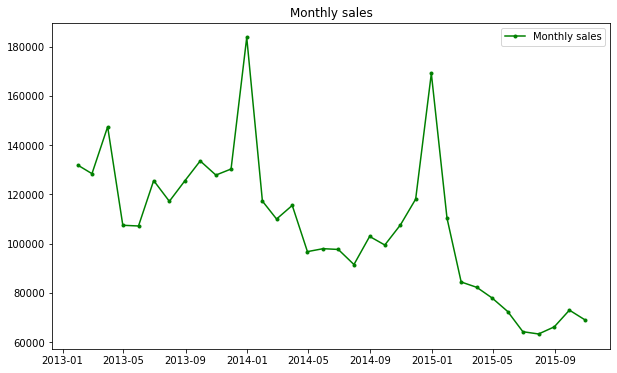

In [87]:
# 월말로 기준으로 date item_cnt_day df 생성 그 후 월간 판매량 추이 그래프 확인 
# 전체적인 판매량만 보여주는 그래프 바로 아래에 전체 shop별 판매량 그래프 보여줌
ts_M = full_df[["date", "item_cnt_day"]].set_index("date").resample("M").sum()

plt.figure(figsize = (10, 6))
plt.plot(ts_M, color = "Green", label = "Monthly sales",marker='.')
plt.title("Monthly sales")
plt.legend();

In [88]:
# 이 그래프를 통해 시간이 지날수록 매출은 지속적으로 감소하고 있고, 크리스마스 시즌에만 높은 매출량을 기록하는 계절성을 확인할 수 있음.

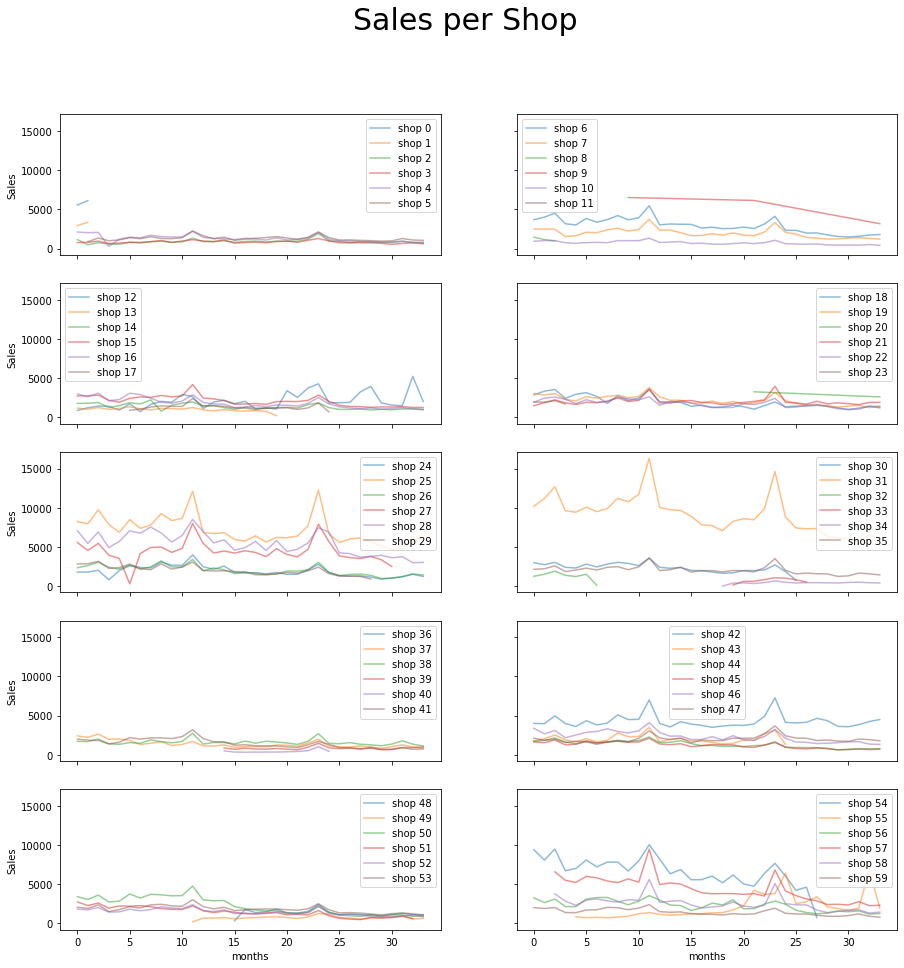

In [89]:
fig,ax = plt.subplots(nrows=5, ncols=2,sharex=True, sharey=True,figsize=(15,15))
fig.suptitle('Sales per Shop', fontsize=30)
ts_shop = full_df.groupby(['shop_id','date_block_num'])['item_cnt_day'].sum().reset_index()
shop_count=0
for i in range(5):
    for j in range(2):
        for z in range(6):
            ax[i,j].plot(ts_shop[ts_shop['shop_id']==shop_count]['date_block_num'],ts_shop[ts_shop['shop_id']==shop_count]['item_cnt_day'],alpha=.5,label='shop '+str(shop_count))
            shop_count += 1
            ax[i,j].legend(loc='best')
# shop별 (월간) 판매 추이 그래프 
for ax in ax.flat:
    ax.set(xlabel='months', ylabel='Sales')
    ax.label_outer()

[Text(0.5, 0, 'item category'), Text(0, 0.5, 'Sales')]

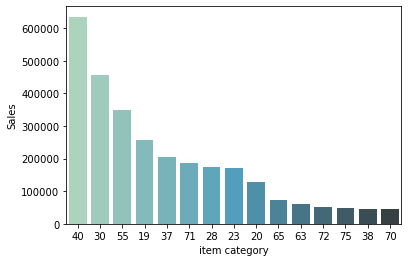

In [90]:
# 가장 많이 팔린 category top 15를 보여주는 그래프 
items_x_cat=full_df.groupby('item_category_id').agg({'item_cnt_day':'sum'})
items_x_cat.reset_index(inplace=True)
items_x_cat=items_x_cat.sort_values('item_cnt_day',ascending=False)
items_x_cat_top=items_x_cat[0:15] 
items_x_cat_top['item_category_id']=items_x_cat_top['item_category_id'].astype(object)
items_x_cat_top=items_x_cat_top.reset_index(drop=True)
barplot=sns.barplot(y='item_cnt_day',x='item_category_id',palette='GnBu_d',data=items_x_cat_top,order=items_x_cat_top.sort_values('item_cnt_day',ascending=False).item_category_id)
barplot.set(xlabel="item category", ylabel = "Sales")

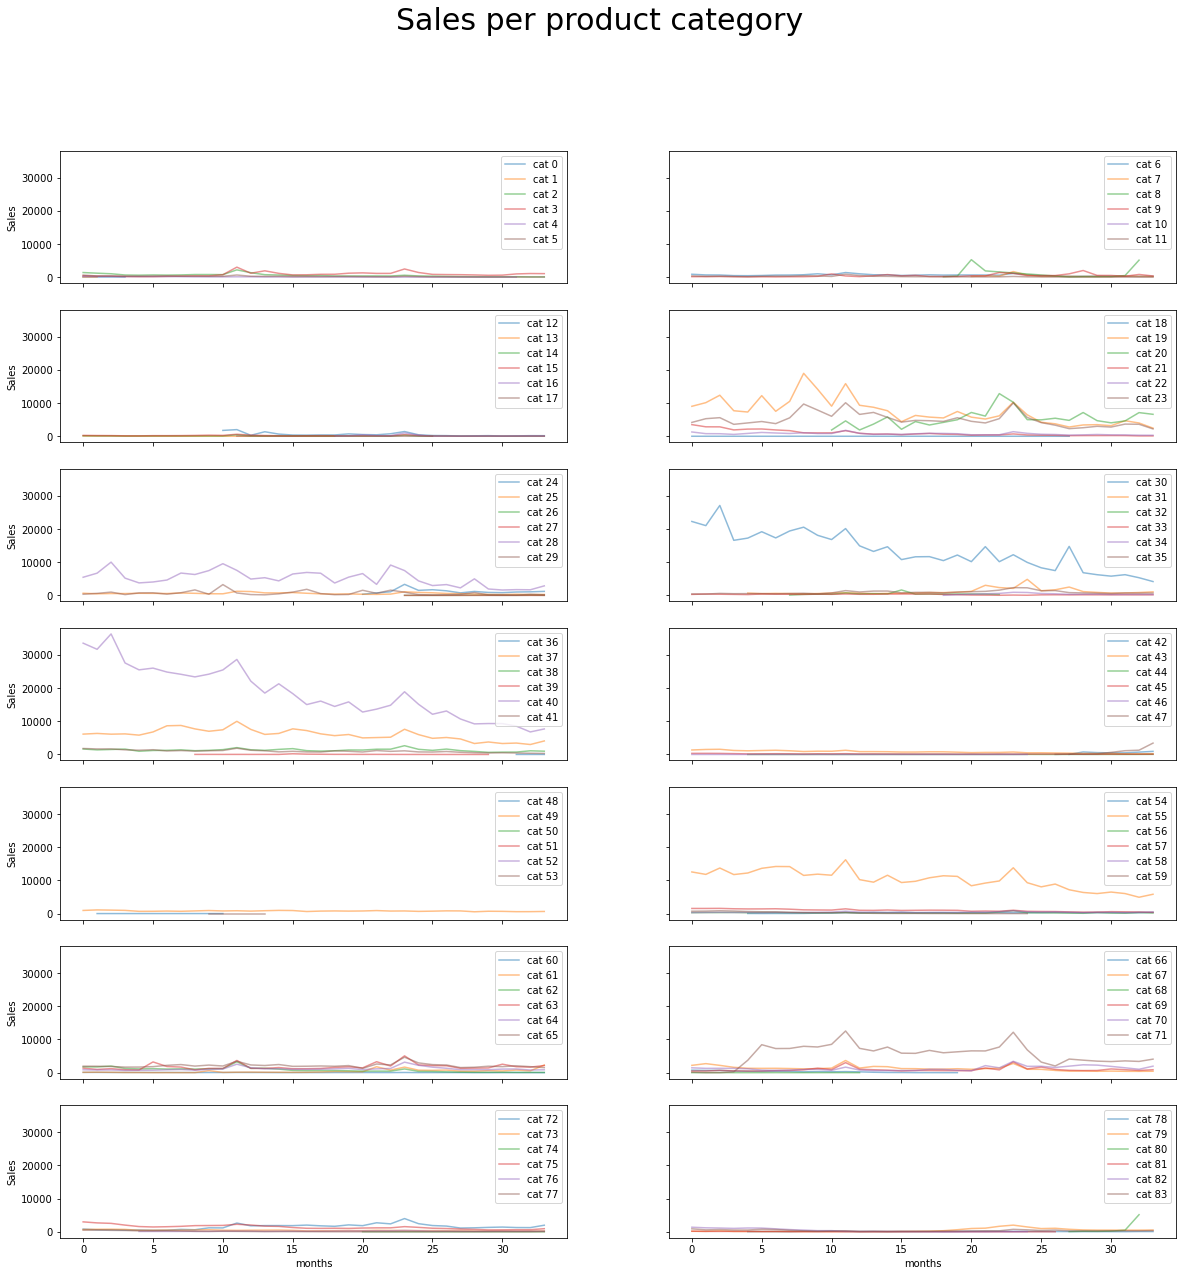

In [91]:
# 전체적인 category를 보았으니 전체 category의 월별 판매량 수치 
fig,ax = plt.subplots(nrows=7, ncols=2,sharex=True, sharey=True,figsize=(20,20))
fig.suptitle('Sales per product category', fontsize=30)
ts_cat = full_df.groupby(['item_category_id','date_block_num'])['item_cnt_day'].sum().reset_index()
cat_count=0
for i in range(7):
    for j in range(2):
        for z in range(6):
            ax[i,j].plot(ts_cat[ts_cat['item_category_id']==cat_count]['date_block_num'],ts_cat[ts_cat['item_category_id']==cat_count]['item_cnt_day'],alpha=.5,label='cat '+str(cat_count))
            cat_count += 1
            ax[i,j].legend(loc='best')

for ax in ax.flat:
    ax.set(xlabel='months', ylabel='Sales')
    ax.label_outer()

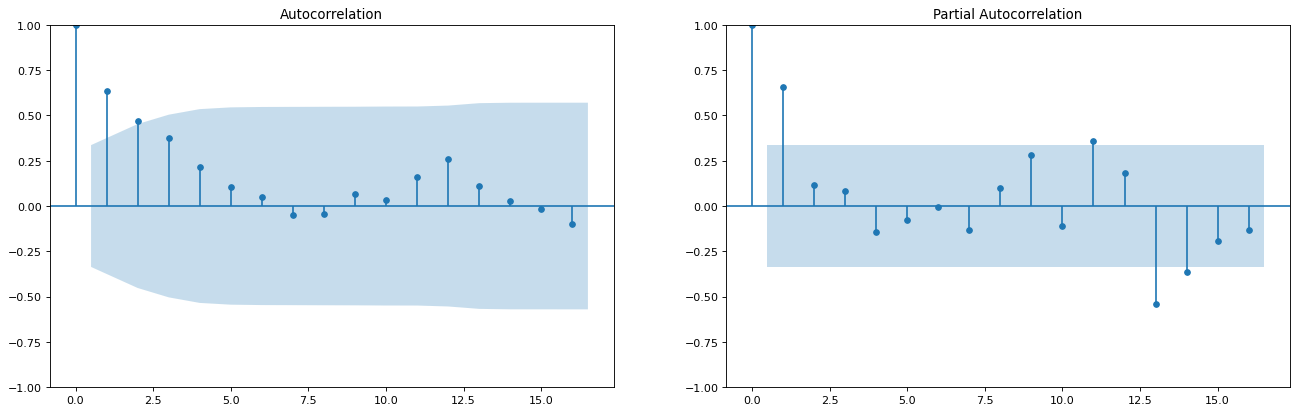

In [92]:
# acf / pacf 그래프 lag가 1,2 달 정도만 유효하고 나머지는 유효한값을 가지기 어렵다 
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (20,6), dpi = 80)
plot_acf(ts_M, ax = ax1, lags = 16)
plot_pacf(ts_M, ax = ax2, lags = 16);

# 시계열이 이전 시간 단계(lag)에서 자신과 얼마나 상관관계가 있는지 찾는 것으로 구성.
# 자기 상관: 직접 및 간접 효과를 고려.
# 부분 자기상관: 직접적인 효과만 고려.
# 파란색 영역은 신뢰 구간을 나타내며 기본적으로 95%로 설정. 이 영역 외부의 값과 시차가 상관 관계가 있을 가능성이 있음을 시사.

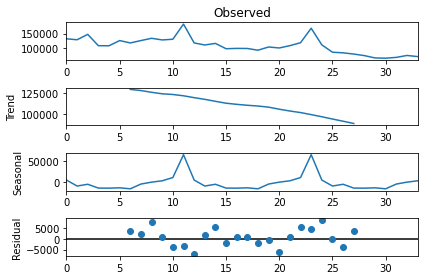

In [93]:
# ts_M 월말 별 아이템 갯수의 합 계절적 연관성을 확인하기위해서 만든 그래프(12월에 급증하는것을 볼수있음 )
# / 감소하는 추세의 그래프 
res = seasonal_decompose(ts_M.values, period=12, model='additive')
fig = res.plot()

In [94]:
# 위에 그래프에서 계절성과 어느정도의 하락하는 추세를 확인  
# pvalue > 0.05 이기때문에 데이터는 고정적이지 않음 (검정과정)
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['ADF Statistic:','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
# 검정의 귀무가설은 시계열이 고정적이지 않고 일종의 시간 종속 구조를 갖는다는 것. >> 추세와 계절성 등의 영향을 받고 있다.
# 대립 가설(귀무 가설 기각)은 시계열이 정상적이라는 것. 결과를 해석하기 위해 p-값을 사용.
# p-값 > 0.05이면 귀무 가설을 채택(데이터는 고정적이지 않다). p-값 <= 0.05이면 귀무 가설을 기각하고 ts가 정상적이라는 결론(대립 가설 채택)을 내린다.

In [95]:
test_stationarity(ts_M)

Results of Dickey-Fuller Test:
ADF Statistic:                 -2.372252
p-value                         0.149722
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [96]:
# z-score 정규화 이상치를 피하는데 특화 
def normalize(ts):
    avg,dev=ts.mean(), ts.std()
    ts=(ts-avg)/dev
    return ts
# 계절성 제거
def remove_seasonality(ts):
    ts= ts-ts.shift(12)
    ts=ts.dropna()
    return ts
# 추이 제거 
def remove_trend(ts):
    ts= ts.diff(1).dropna()
    return ts

Text(0, 0.5, 'Total de ventas')

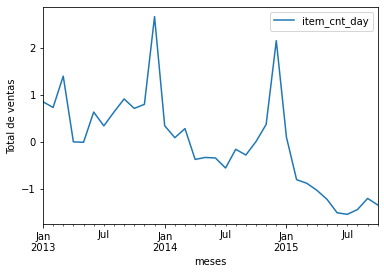

In [97]:
# 정규화후 아이템 판매량 그래프 
# Normalize TS
ts_norm=normalize(ts_M)
ts_norm.plot()
plt.xlabel('meses')
plt.ylabel('Total de ventas')

Results of Dickey-Fuller Test:
ADF Statistic:                 -3.181500
p-value                         0.021081
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


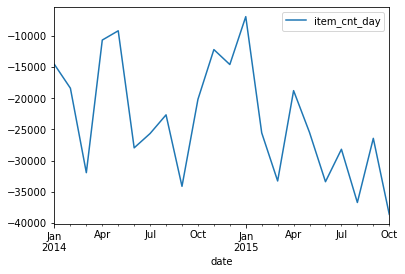

In [98]:
# Remove seasonality
# 계절성 제거후 판매량 그래프 
ts_est=remove_seasonality(ts_M)
ts_est.plot()
test_stationarity(ts_est)

Results of Dickey-Fuller Test:
ADF Statistic:                -1.331376e+01
p-value                        6.666090e-25
#Lags Used                     1.000000e+01
Number of Observations Used    2.200000e+01
Critical Value (1%)           -3.769733e+00
Critical Value (5%)           -3.005426e+00
Critical Value (10%)          -2.642501e+00
dtype: float64


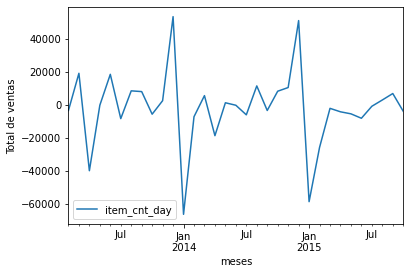

In [99]:
#Remove trend
ts_trend=remove_trend(ts_M)
ts_trend.plot()
plt.xlabel('meses')
plt.ylabel('Total de ventas')
test_stationarity(ts_trend)

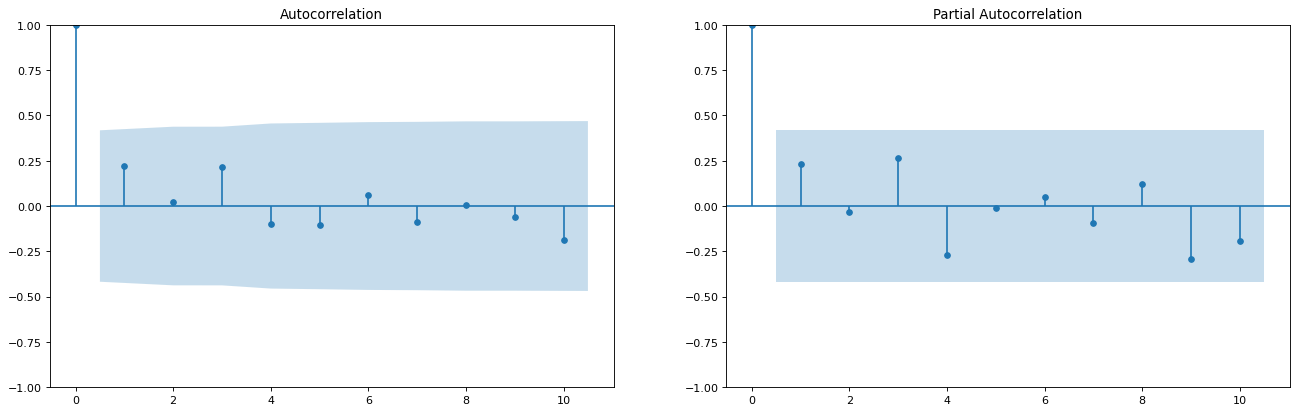

In [100]:
# 계절성 제거 후의 acf, pacf 그래프 구현 
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,6), dpi = 80)
plot_acf(ts_est, ax = ax1, lags = 10)
plot_pacf(ts_est, ax = ax2, lags = 10);

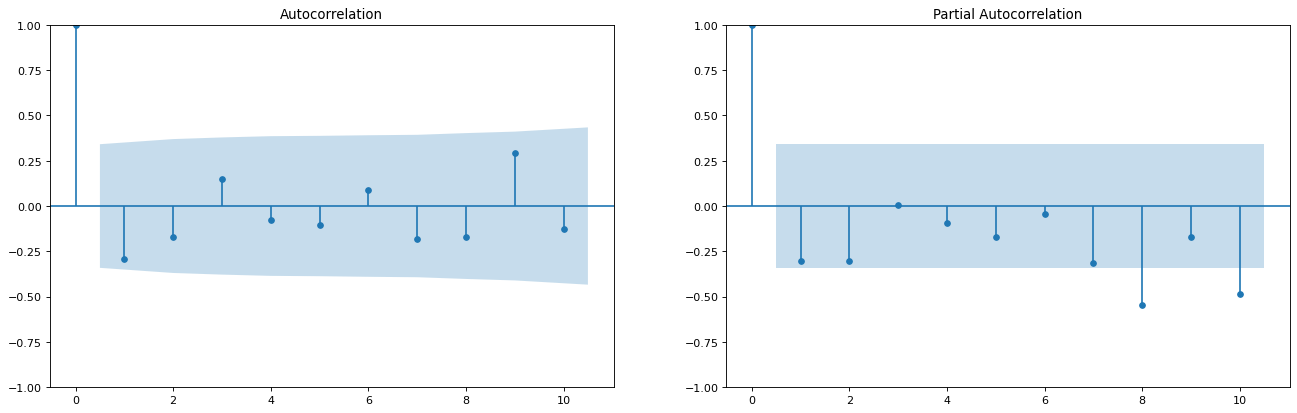

In [101]:
# 추이 제거후의 acf, pacf 그래프 
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,6), dpi = 80)
plot_acf(ts_trend, ax = ax1, lags = 10)
plot_pacf(ts_trend, ax = ax2, lags = 10);

In [102]:
# preds에 shop_id[i], Y[i]값 추가 
def create_pred_list(X,Y):
    lista_shops=X['shop_id'].tolist()
    preds=[]
    for shop in range(0,len(Y)):
        preds.append(np.array([lista_shops[shop],Y[shop]]))
    return preds

# 제출파일에 합쳐주는 함수 
def submission_df(df_forc_items):
    df_final=pd.merge(df_sub,df_forc_items,how='left',on=['ID'])
    df_final.fillna(0,inplace=True)
    return df_final

# valid와 pred를 merge한뒤 obs와 pred값의 평균제곱오차(잔차의 제곱에대한 평균)의 제곱근
def evaluation(df_pred):
    df_eval=pd.merge(df_valid,df_pred, on=['ID'],how='inner')
    error = sqrt(mean_squared_error(df_eval['obs'].values, df_eval['pred'].values))
    return error

In [103]:
#????? 
# 중간값 예측을 사용하기위한 함수
def middleout_forecasting(predictions,months_weights): 
    month=33-months_weights
    df_forecast=pd.DataFrame(predictions,columns=['shop_id','forecast_shop'])
    
    # shop, item id 별 판매량 merge를 위해서 shop_id들어감 
    #we calculate the number of sales per item in each store of the las "month" months
    sales_gb_item=df_train[df_train['date_block_num']>month].groupby(['shop_id','item_id'])["item_cnt_day"].sum()  # 최신 월별 매출량
    sales_gb_item=pd.DataFrame(sales_gb_item)
    sales_gb_item.reset_index(inplace=True)
    sales_gb_item.rename(columns={'item_cnt_day':'item_sales'},inplace=True)
    
    # shop_id 별 판매량 
    #we calculate the number of sales store of the las "month" months
    sales_gb_shop=df_train[df_train['date_block_num']>month].groupby(['shop_id'])["item_cnt_day"].sum()
    sales_gb_shop=pd.DataFrame(sales_gb_shop)
    sales_gb_shop.reset_index(inplace=True)
    sales_gb_shop.rename(columns={'item_cnt_day':'shop_sales'},inplace=True)
    
    # 두개 df 합친 후 item 판매량 / shop 판매량으로 shop별 판매량 계산 
    #we calculate the proportion of the sales for each item in every shop in the last "month" months
    sales_gb_full=pd.merge(sales_gb_item,sales_gb_shop,how='left',on=['shop_id'])
    sales_gb_full=pd.merge(sales_gb_full,df_test,how='left',on=['shop_id','item_id'])
    sales_gb_full['weights']=sales_gb_full['item_sales']/sales_gb_full['shop_sales']
    sales_gb_full.drop(['item_sales','shop_sales'],axis=1,inplace=True)
    # 전체 상점에서 각각의 상품들이 월마다 얼만큼 팔렸는지.
    
    # merge후 각각 상점에 대한 예측값 계산
    #we calculate the forecast for each item in every store
    df_calc=pd.merge(sales_gb_full,df_forecast,how='left',on=['shop_id'])
    df_calc['item_cnt_month']=(df_calc['weights']*df_calc['forecast_shop']).clip(0,20) #clip the result to submit
    df_calc.drop(['shop_id','item_id','weights','forecast_shop'],axis=1,inplace=True)
    
    return df_calc

In [104]:
# 검정 파트 제작 
#df validation, month 33
df_valid=full_df[full_df['date_block_num']==33].groupby(['shop_id','item_id'])["item_cnt_day"].sum().clip(0,20).to_frame()
df_valid.reset_index(inplace=True)

df_valid=pd.merge(df_valid,df_test, on=['shop_id','item_id'],how='left').sort_values('ID')
df_valid.drop(['item_id','shop_id'],axis=1,inplace=True)
df_valid.rename(columns={'item_cnt_day':'obs'},inplace=True)
df_valid=df_valid[['ID','obs']]

![Alt text](Graphical_method.png)
---
- 박스-젠킨스의 Graphical_method

In [105]:
# seasonal 제거(함수)
ts_arima=remove_seasonality(ts_M)

In [106]:
# 최적화된 arima 모델에서의 p,d,q 값 확인 
p = range(0,4)
d = range(1,2)
q = range(0,4)
pdq = list(itertools.product(p,d,q))

aic=[]
for i in pdq:
    model = sm.tsa.arima.ARIMA(ts_arima.values, order=(i))
    model_fit = model.fit()
    print(f'ARIMA: {i} >> AIC: {round(model_fit.aic,2)}')
    aic.append(round(model_fit.aic,2))

ARIMA: (0, 1, 0) >> AIC: 452.5
ARIMA: (0, 1, 1) >> AIC: 449.78
ARIMA: (0, 1, 2) >> AIC: 451.23
ARIMA: (0, 1, 3) >> AIC: 452.85
ARIMA: (1, 1, 0) >> AIC: 452.42
ARIMA: (1, 1, 1) >> AIC: 451.42
ARIMA: (1, 1, 2) >> AIC: 452.35
ARIMA: (1, 1, 3) >> AIC: 454.35
ARIMA: (2, 1, 0) >> AIC: 452.23
ARIMA: (2, 1, 1) >> AIC: 454.19
ARIMA: (2, 1, 2) >> AIC: 454.35
ARIMA: (2, 1, 3) >> AIC: 453.76
ARIMA: (3, 1, 0) >> AIC: 454.68
ARIMA: (3, 1, 1) >> AIC: 455.45
ARIMA: (3, 1, 2) >> AIC: 456.35
ARIMA: (3, 1, 3) >> AIC: 454.83


In [107]:
# 최적화된 p,d,q값 확인
optimal = [(pdq[i],j) for i,j in enumerate(aic) if j == min(aic)]
optimal

[((0, 1, 1), 449.78)]

                               SARIMAX Results                                
Dep. Variable:           item_cnt_day   No. Observations:                   22
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -222.891
Date:                Wed, 20 Jul 2022   AIC                            449.782
Time:                        11:33:32   BIC                            451.871
Sample:                    01-31-2014   HQIC                           450.235
                         - 10-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6431      0.233     -2.765      0.006      -1.099      -0.187
sigma2      9.721e+07   2.13e-10   4.57e+17      0.000    9.72e+07    9.72e+07
Ljung-Box (L1) (Q):                   0.00   Jarque-

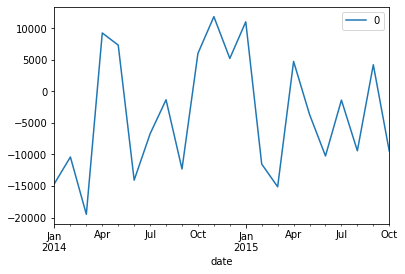

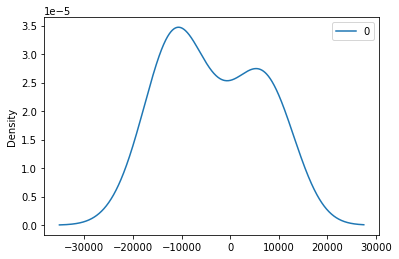

In [108]:
# arima 모델에 적용
model = sm.tsa.arima.ARIMA(ts_arima, order=(0,1,1)) # order = (p,q,r)
model_fit = model.fit()
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

In [109]:
# shop_id / 월별 판매량 데이터프레임 생성 
# NIVEL DE TIENDA
ts_shop=df_train.groupby(["date_block_num",'shop_id'])["item_cnt_day"].sum()
ts_shop=ts_shop.unstack(level=1)
ts_shop=ts_shop.fillna(0)

In [110]:
ts_shop.tail()

shop_id          0    1      2      3      4       5       6       7    8   \
date_block_num                                                               
29              0.0  0.0  807.0  676.0  797.0   955.0  1546.0  1238.0  0.0   
30              0.0  0.0  789.0  542.0  844.0   994.0  1487.0  1327.0  0.0   
31              0.0  0.0  943.0  668.0  948.0  1297.0  1576.0  1411.0  0.0   
32              0.0  0.0  825.0  749.0  734.0  1098.0  1728.0  1292.0  0.0   
33              0.0  0.0  727.0  616.0  831.0  1054.0  1803.0  1216.0  0.0   

shop_id             9   ...      50     51      52      53   54      55  \
date_block_num          ...                                               
29                 0.0  ...   902.0  659.0   822.0  1079.0  0.0  1909.0   
30                 0.0  ...  1128.0  748.0   829.0  1261.0  0.0  1658.0   
31                 0.0  ...  1081.0  916.0   938.0  1321.0  0.0  1976.0   
32                 0.0  ...   906.0  624.0  1091.0  1231.0  0.0  6867.0   
33              3188.0  ...   950.0    0.0   852.0  1065.0  0.0  1972.0   

shop_id             56      57      58      59  
date_block_num                                  
29              1571.0  2447.0  1560.0   913.0  
30              1493.0  2357.0  1691.0   998.0  
31              1605.0  2788.0  1743.0  1216.0  
32              1198.0  2270.0  1323.0   915.0  
33              1267.0  2319.0  1448.0   792.0  

[5 rows x 60 columns]

In [111]:
# 마지막달 판매량이 0 인가게는 closed shop으로 새로운 변수 생성
closed_shops=(ts_shop[33:]==0).all()
closed_shops=np.array(closed_shops.index[closed_shops==True])

In [112]:
# 예측 수치가 정확한지 확인 
def train_evaluation_arima(ts,i):
    predictions = list()
    
    # train test 분리 
    # shop별 아리마 분석 
    X=ts[i].values
    train, test = X[0:33], X[33:]
    history = [x for x in train]
    print('-----------------------shop %f--------------------------' % i)
    # shop이 닫은곳은 예측치를 0으로 설정 
    if (i in closed_shops or sum(history)==0):
        for t in range(len(test)):
            	predictions.append(0)
    
    # arima 모델에 넣어주는 과정 
    else:
        for t in range(len(test)):
            model = sm.tsa.arima.ARIMA(history, order=(0,1,1))
            model_fit = model.fit()
            output = model_fit.predict(1, len(history)+1, typ='levels')
            yhat = output[-1]
            predictions.append(yhat)
            obs = test[t]
            history.append(obs)
            
            print('predicted=%f, expected=%f' % (yhat, obs))
            error = sqrt(mean_squared_error(test, predictions))
            print('Test MSE: %.3f' % error)
            
            # shop별 예측치와 실측치 구분 
            plt.plot(history,label='obs')
            plt.plot(output, label='pred',ls='--')
            plt.xticks(range(0,len(history)+1))
            plt.legend()
            plt.title('shop '+str(i))
            plt.show()
        
    predictions_series=pd.Series(predictions)
    return np.append(np.array(i),predictions_series.values.transpose())

-----------------------shop 0.000000--------------------------
-----------------------shop 1.000000--------------------------
-----------------------shop 2.000000--------------------------
predicted=886.525089, expected=727.000000
Test MSE: 159.525


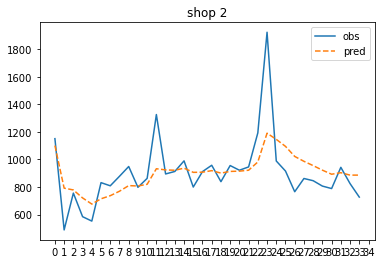

-----------------------shop 3.000000--------------------------
predicted=698.051033, expected=616.000000
Test MSE: 82.051


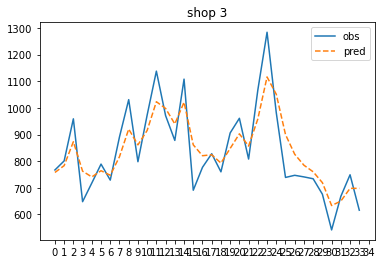

-----------------------shop 4.000000--------------------------
predicted=908.541040, expected=831.000000
Test MSE: 77.541


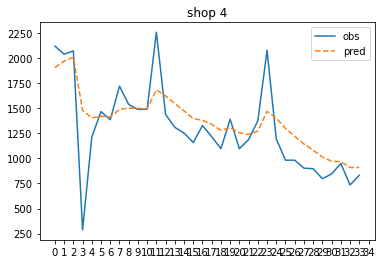

-----------------------shop 5.000000--------------------------
predicted=1129.106588, expected=1054.000000
Test MSE: 75.107


-----------------------shop 6.000000--------------------------
predicted=1662.558663, expected=1803.000000
Test MSE: 140.441


-----------------------shop 7.000000--------------------------
predicted=1322.035547, expected=1216.000000
Test MSE: 106.036


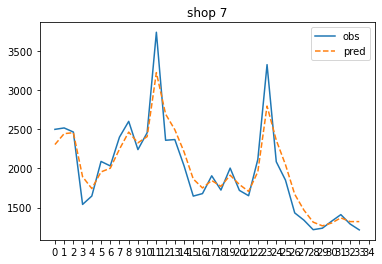

-----------------------shop 8.000000--------------------------
-----------------------shop 9.000000--------------------------
predicted=376.362063, expected=3188.000000
Test MSE: 2811.638


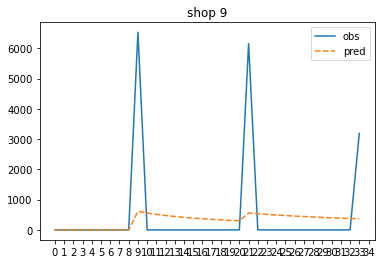

-----------------------shop 10.000000--------------------------
predicted=482.455656, expected=428.000000
Test MSE: 54.456


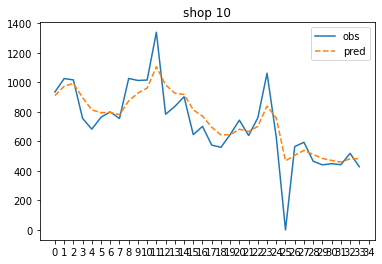

-----------------------shop 11.000000--------------------------
-----------------------shop 12.000000--------------------------
predicted=2836.875253, expected=2016.000000
Test MSE: 820.875


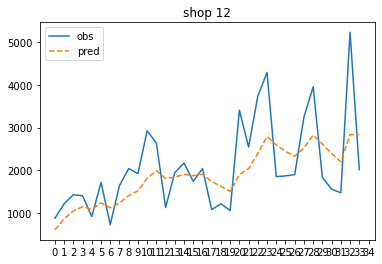

-----------------------shop 13.000000--------------------------
-----------------------shop 14.000000--------------------------
predicted=1070.113542, expected=1007.000000
Test MSE: 63.114


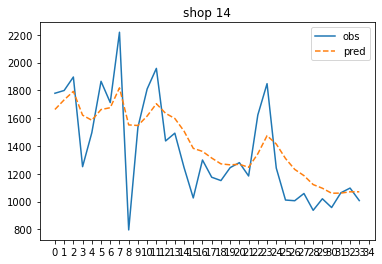

-----------------------shop 15.000000--------------------------
predicted=1296.120754, expected=1248.000000
Test MSE: 48.121


-----------------------shop 16.000000--------------------------
predicted=1118.041400, expected=966.000000
Test MSE: 152.041


-----------------------shop 17.000000--------------------------
-----------------------shop 18.000000--------------------------
predicted=1285.348727, expected=1212.000000
Test MSE: 73.349


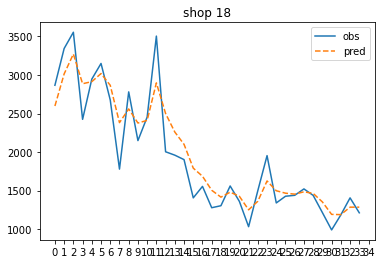

-----------------------shop 19.000000--------------------------
predicted=1342.357842, expected=1453.000000
Test MSE: 110.642


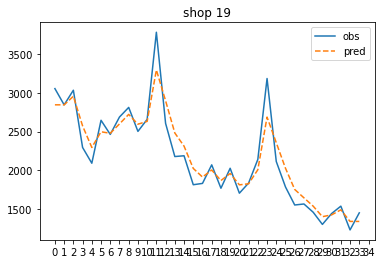

-----------------------shop 20.000000--------------------------
predicted=98.120911, expected=2611.000000
Test MSE: 2512.879


-----------------------shop 21.000000--------------------------
predicted=2010.909265, expected=1913.000000
Test MSE: 97.909


-----------------------shop 22.000000--------------------------
predicted=1258.005312, expected=1338.000000
Test MSE: 79.995


-----------------------shop 23.000000--------------------------
-----------------------shop 24.000000--------------------------
predicted=1329.588444, expected=1228.000000
Test MSE: 101.588


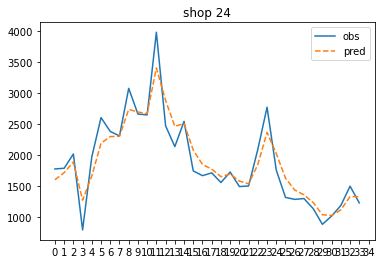

-----------------------shop 25.000000--------------------------
predicted=5445.117249, expected=6261.000000
Test MSE: 815.883


-----------------------shop 26.000000--------------------------
predicted=1342.804287, expected=1412.000000
Test MSE: 69.196


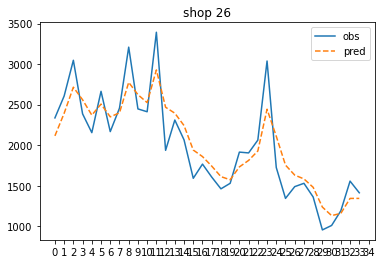

-----------------------shop 27.000000--------------------------
-----------------------shop 28.000000--------------------------
predicted=3309.553470, expected=3021.000000
Test MSE: 288.553


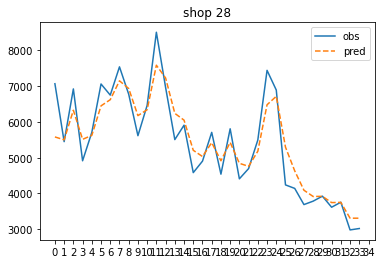

-----------------------shop 29.000000--------------------------
-----------------------shop 30.000000--------------------------
-----------------------shop 31.000000--------------------------
predicted=6373.892037, expected=6119.000000
Test MSE: 254.892


-----------------------shop 32.000000--------------------------
-----------------------shop 33.000000--------------------------
-----------------------shop 34.000000--------------------------
predicted=424.331979, expected=385.000000
Test MSE: 39.332


-----------------------shop 35.000000--------------------------
predicted=1549.314580, expected=1421.000000
Test MSE: 128.315


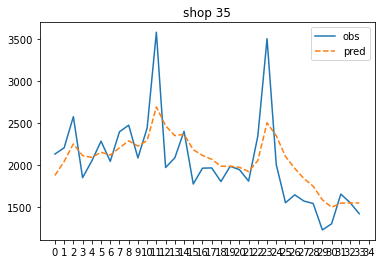

-----------------------shop 36.000000--------------------------
-----------------------shop 37.000000--------------------------
predicted=1049.741359, expected=833.000000
Test MSE: 216.741


-----------------------shop 38.000000--------------------------
predicted=1598.894839, expected=1114.000000
Test MSE: 484.895


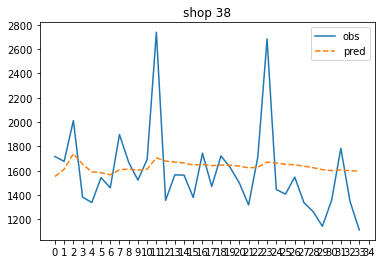

-----------------------shop 39.000000--------------------------
predicted=892.325190, expected=998.000000
Test MSE: 105.675


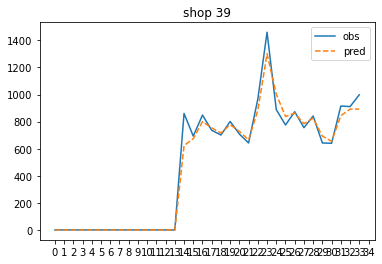

-----------------------shop 40.000000--------------------------
-----------------------shop 41.000000--------------------------
predicted=719.931774, expected=743.000000
Test MSE: 23.068


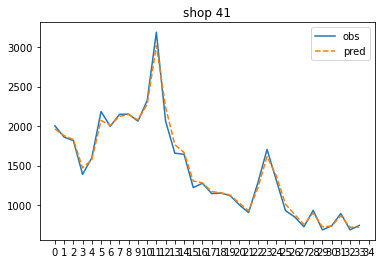

-----------------------shop 42.000000--------------------------
predicted=4209.288301, expected=4498.000000
Test MSE: 288.712


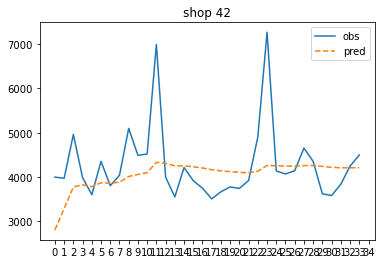

-----------------------shop 43.000000--------------------------
-----------------------shop 44.000000--------------------------
predicted=751.154978, expected=780.000000
Test MSE: 28.845


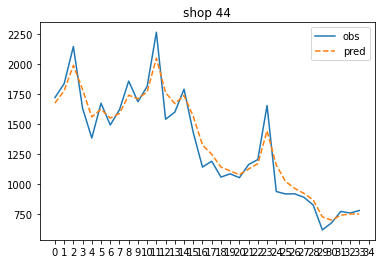

-----------------------shop 45.000000--------------------------
predicted=686.943117, expected=702.000000
Test MSE: 15.057


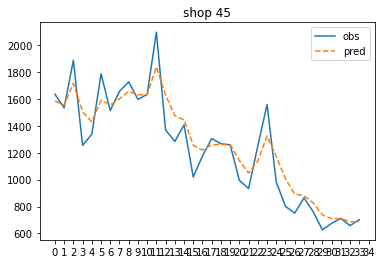

-----------------------shop 46.000000--------------------------
predicted=1492.676453, expected=1322.000000
Test MSE: 170.676


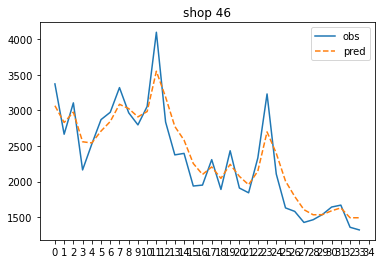

-----------------------shop 47.000000--------------------------
predicted=1924.172502, expected=1785.000000
Test MSE: 139.173


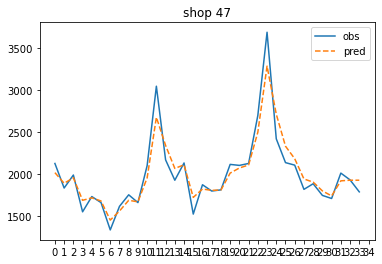

-----------------------shop 48.000000--------------------------
predicted=1141.626740, expected=1119.000000
Test MSE: 22.627


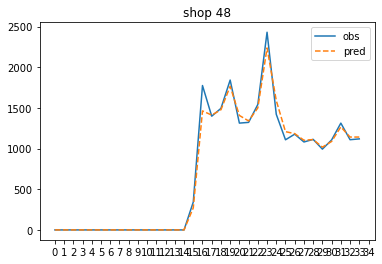

-----------------------shop 49.000000--------------------------
predicted=450.120058, expected=649.000000
Test MSE: 198.880


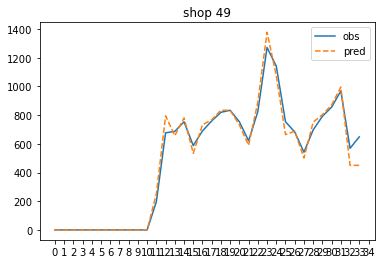

-----------------------shop 50.000000--------------------------
predicted=966.814379, expected=950.000000
Test MSE: 16.814


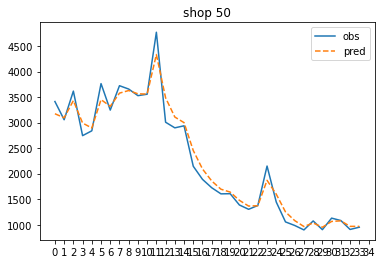

-----------------------shop 51.000000--------------------------
-----------------------shop 52.000000--------------------------
predicted=998.115779, expected=852.000000
Test MSE: 146.116


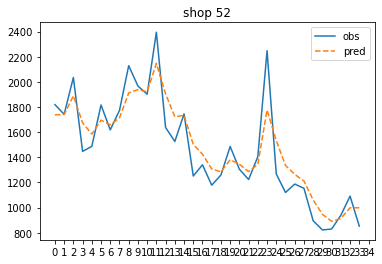

-----------------------shop 53.000000--------------------------
predicted=1253.124808, expected=1065.000000
Test MSE: 188.125


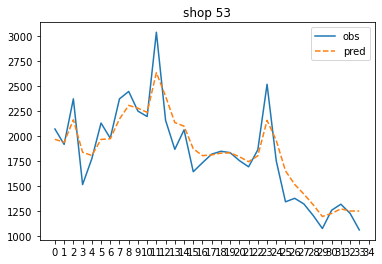

-----------------------shop 54.000000--------------------------
-----------------------shop 55.000000--------------------------
predicted=4787.769421, expected=1972.000000
Test MSE: 2815.769


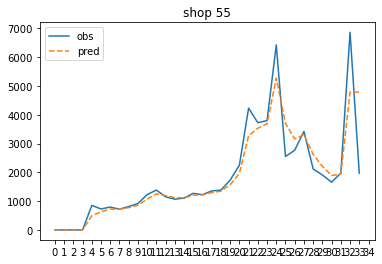

-----------------------shop 56.000000--------------------------
predicted=1343.063719, expected=1267.000000
Test MSE: 76.064


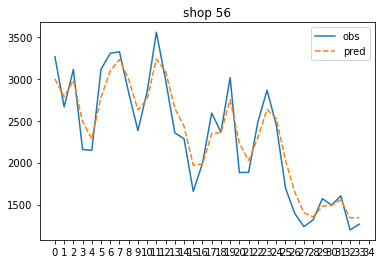

-----------------------shop 57.000000--------------------------
predicted=2416.074166, expected=2319.000000
Test MSE: 97.074


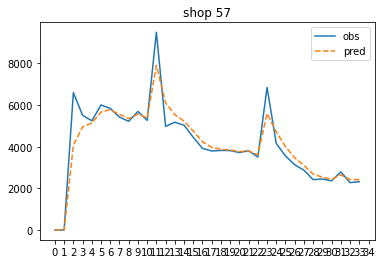

-----------------------shop 58.000000--------------------------
predicted=1533.335043, expected=1448.000000
Test MSE: 85.335


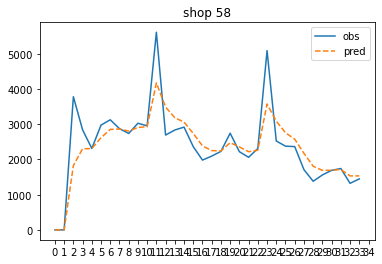

-----------------------shop 59.000000--------------------------
predicted=985.234999, expected=792.000000
Test MSE: 193.235


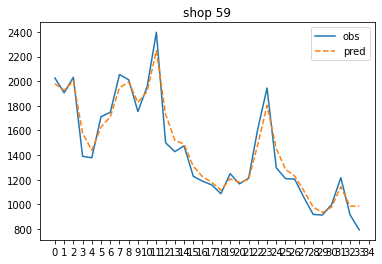

In [113]:
lista_pred_arima=[]
for i in ts_shop.columns.tolist():
    lista_pred_arima.append(train_evaluation_arima(ts_shop,i))

In [114]:
df_pred_arima=middleout_forecasting(lista_pred_arima,3)
df_pred_arima=submission_df(df_pred_arima) # ID 와 merge 
df_pred_arima.rename(columns={'item_cnt_month_y':'pred'},inplace=True)

In [115]:
error_arima = evaluation(df_pred_arima)
print('Test MSE: %.3f' % error_arima)

Test MSE: 1.617


In [116]:
# 실제 예측진행 함수
def forecast_arima_shops(ts,i):
    predictions = list()
    train=ts[i].values
    
    if (i in closed_shops or sum(train)==0):
        predictions.append(0)
    else:
        model = sm.tsa.arima.ARIMA(train, order=(0,1,1))
        model_fit = model.fit()
        output = model_fit.predict(1, len(train)+1, typ='levels')
        yhat = output[-1]
        predictions.append(yhat)

        plt.plot(train,label='obs')
        plt.plot(output, label='pred',ls='--')
        plt.xticks(range(0,len(train)+1))
        plt.legend()
        plt.title('shop '+str(i))
        plt.show()
        
    predictions_series=pd.Series(predictions)
    return np.append(np.array(i),predictions_series.values.transpose())

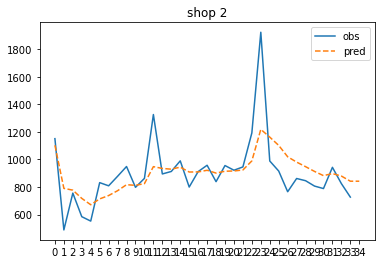

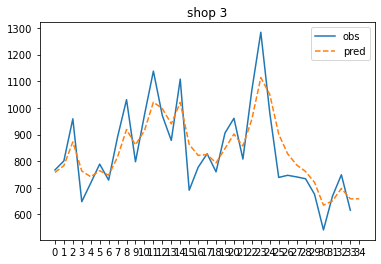

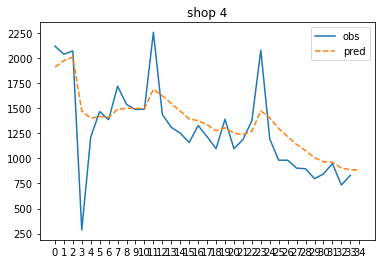

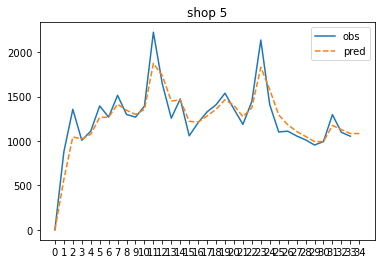

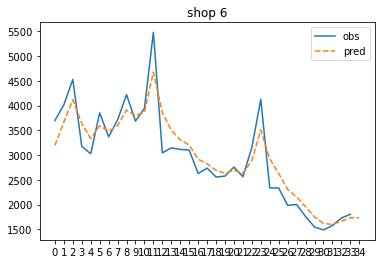

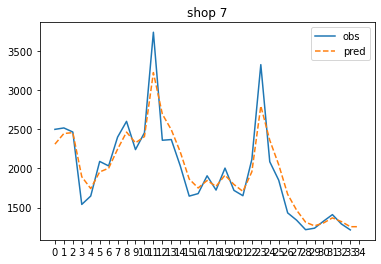

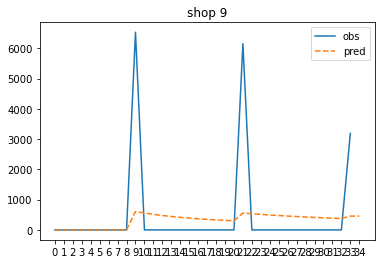

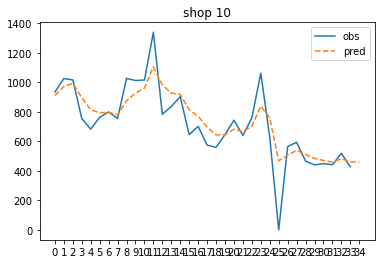

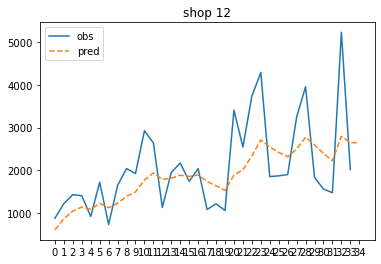

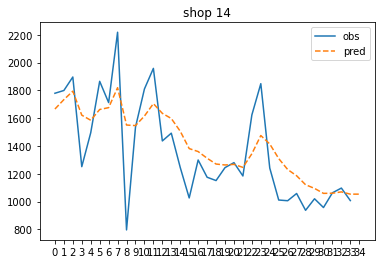

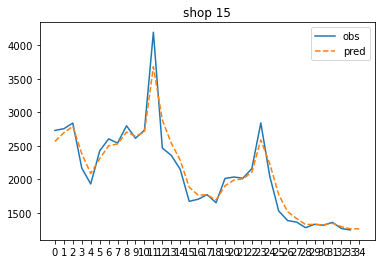

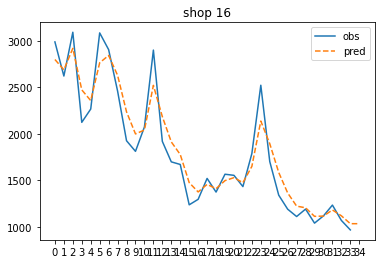

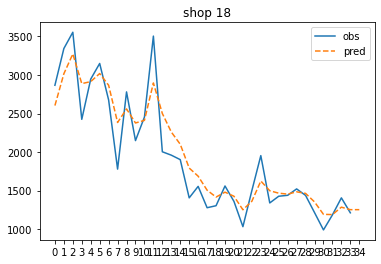

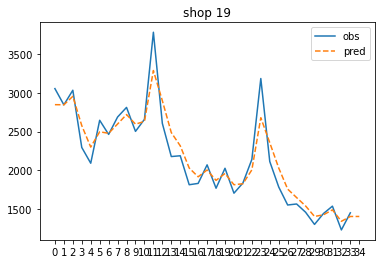

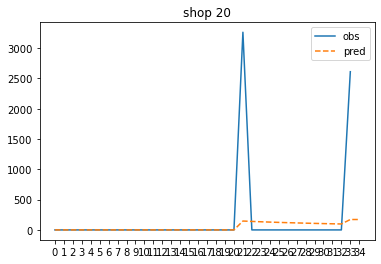

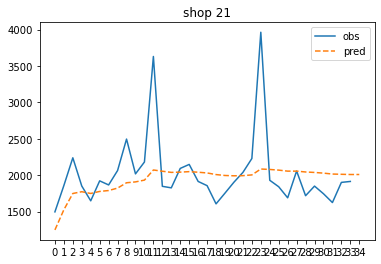

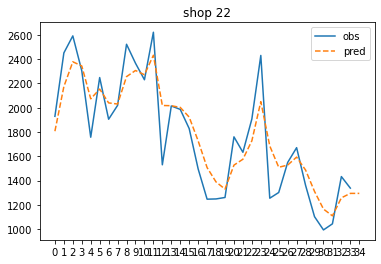

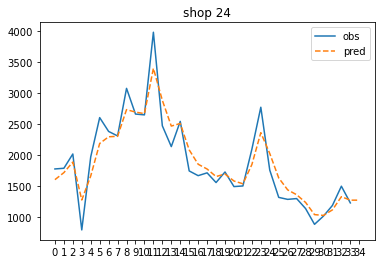

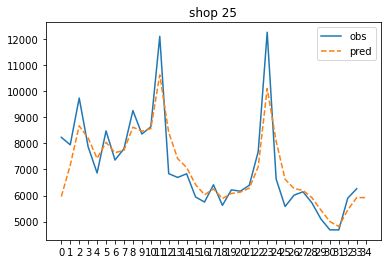

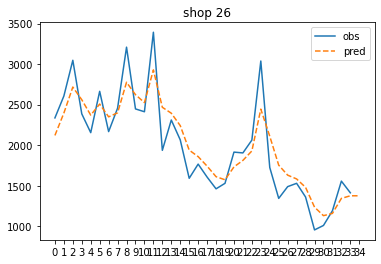

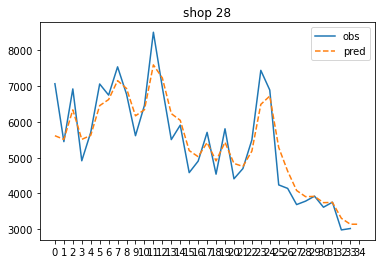

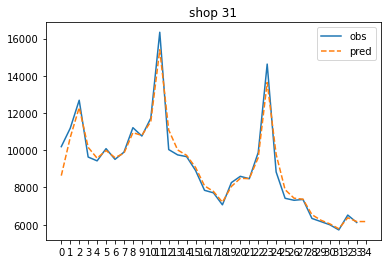

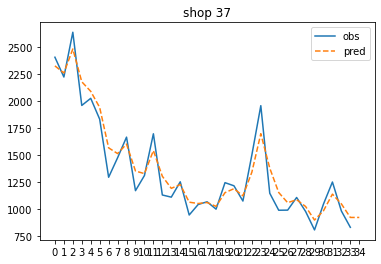

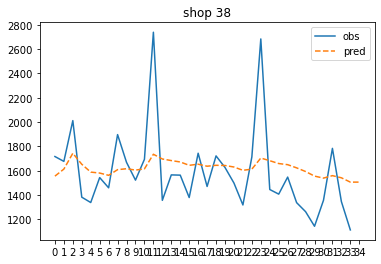

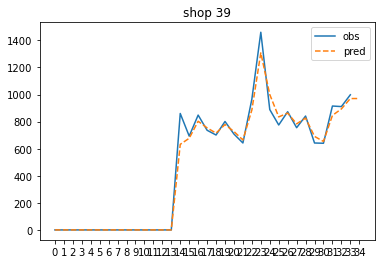

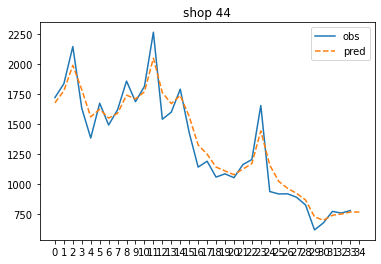

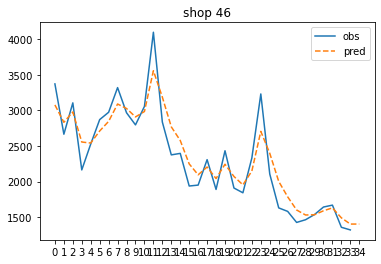

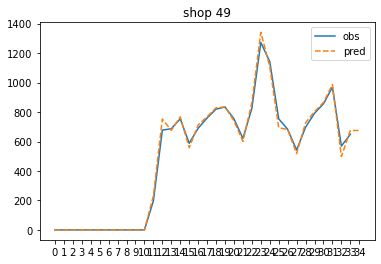

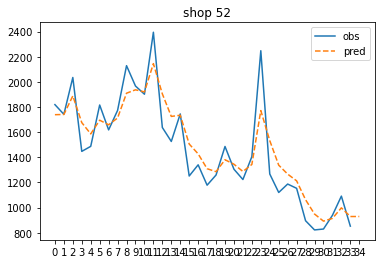

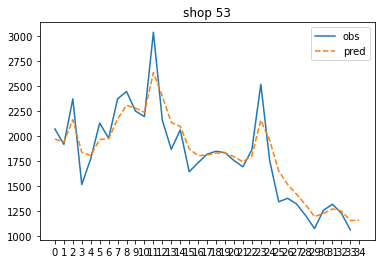

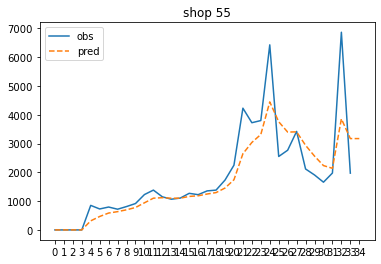

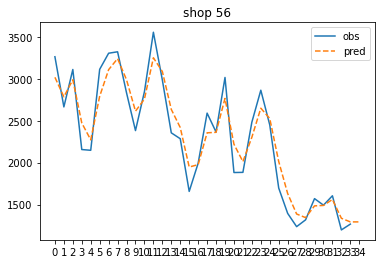

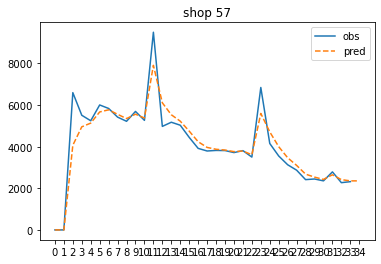

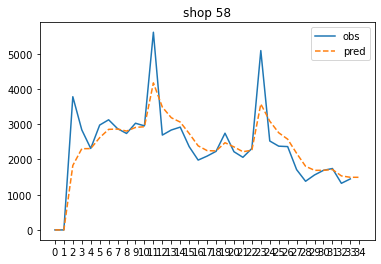

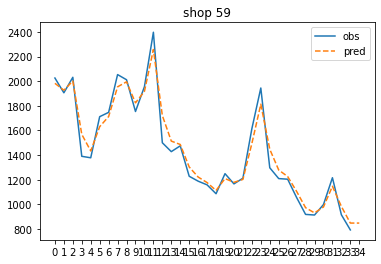

In [117]:
lista_pred_arima_test=[]
for i in ts_shop.columns.tolist():
    lista_pred_arima_test.append(forecast_arima_shops(ts_shop,i))

In [118]:
df_forecast_items=middleout_forecasting(lista_pred_arima_test,3)

In [119]:
# df_final=submission_df(df_forecast_items)
# df_final.to_csv('submission_arima_1.csv', index=False)

## Sarima

In [120]:
ts_arima=remove_seasonality(ts_M)

In [121]:
# best arima 모델 확인
auto_arima_model = auto_arima(ts_arima, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=12, seasonal=True,
                             d=1, D=1,
                             max_P=3, max_Q=3,   
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=False)

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=199.790, Time=0.01 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=198.047, Time=0.02 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=199.132, Time=0.04 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=200.697, Time=0.08 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=197.361, Time=0.02 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=198.999, Time=0.03 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=200.727, Time=0.06 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=202.529, Time=0.13 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=199.361, Time=0.04 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=202.727, Time=0.06 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=204.529, Time=0.13 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=201.361, Time=0.08 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=204.727, Time=0.11 sec
 ARIMA(0,1,1)(0,1,

In [122]:
# Best model:  ARIMA(0,1,3)(0,1,1)[12]

                                      SARIMAX Results                                       
Dep. Variable:                         item_cnt_day   No. Observations:                   22
Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 12)   Log Likelihood                 -87.876
Date:                              Wed, 20 Jul 2022   AIC                            185.753
Time:                                      11:34:03   BIC                            186.739
Sample:                                  01-31-2014   HQIC                           183.625
                                       - 10-31-2015                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.3436      0.772     -1.740      0.082      -2.857       0.170
ma.L2          0.93

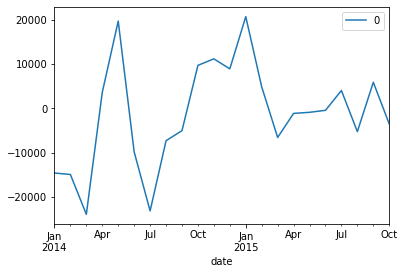

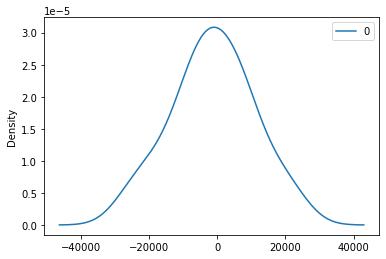

In [123]:
model = SARIMAX(ts_arima, order=(0,1,3), seasonal_order=(0,1,1,12))
model_fit = model.fit()
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

In [124]:
# NIVEL DE TIENDA
ts_shop=df_train.groupby(["date_block_num",'shop_id'])["item_cnt_day"].sum()
ts_shop=ts_shop.unstack(level=1)
ts_shop=ts_shop.fillna(0)

In [125]:
closed_shops=(ts_shop[33:]==0).all()
closed_shops=np.array(closed_shops.index[closed_shops==True])

In [126]:
# 사리마 예측의 정확도 측정
def train_evaluation_arima(ts,i):
    predictions = list()
    
    X=ts[i].values
    train, test = X[0:33], X[33:]
    history = [x for x in train]
    print('-----------------------shop %f--------------------------' % i)
    if (i in closed_shops or sum(history)==0):
        for t in range(len(test)):
            	predictions.append(0)
    else:
        for t in range(len(test)):
            model = SARIMAX(history, order=(0,1,3), seasonal_order=(0,1,1,12))
            model_fit = model.fit()
            output = model_fit.predict(1, len(history)+1, typ='levels')
            yhat = output[-1]
            predictions.append(yhat)
            obs = test[t]
            history.append(obs)
            
            print('predicted=%f, expected=%f' % (yhat, obs))
            error = sqrt(mean_squared_error(test, predictions))
            print('Test MSE: %.3f' % error)
            
            plt.plot(history,label='obs')
            plt.plot(output, label='pred',ls='--')
            plt.xticks(range(0,len(history)+1))
            plt.legend()
            plt.title('shop '+str(i))
            plt.show()
        
    predictions_series=pd.Series(predictions)
    return np.append(np.array(i),predictions_series.values.transpose())

-----------------------shop 0.000000--------------------------
-----------------------shop 1.000000--------------------------
-----------------------shop 2.000000--------------------------
predicted=1093.847508, expected=727.000000
Test MSE: 366.848


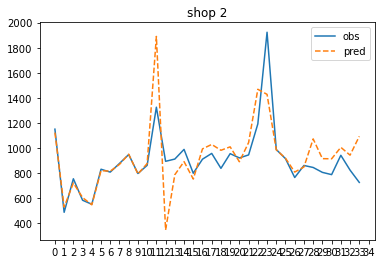

-----------------------shop 3.000000--------------------------
predicted=877.971700, expected=616.000000
Test MSE: 261.972


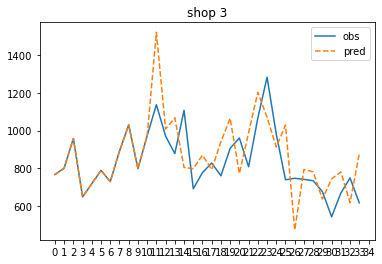

-----------------------shop 4.000000--------------------------
predicted=1139.216604, expected=831.000000
Test MSE: 308.217


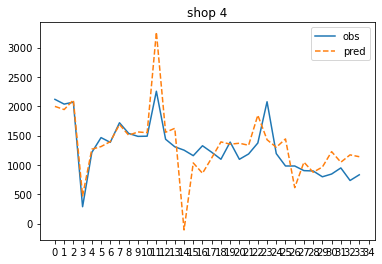

-----------------------shop 5.000000--------------------------
predicted=1536.023381, expected=1054.000000
Test MSE: 482.023


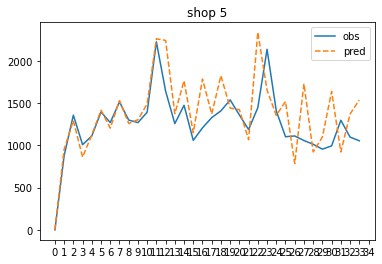

-----------------------shop 6.000000--------------------------
predicted=2169.163114, expected=1803.000000
Test MSE: 366.163


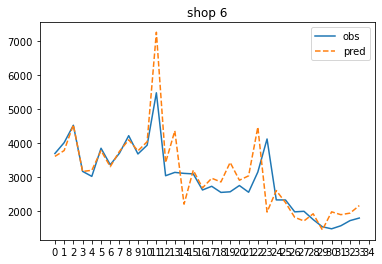

-----------------------shop 7.000000--------------------------
predicted=1647.774343, expected=1216.000000
Test MSE: 431.774


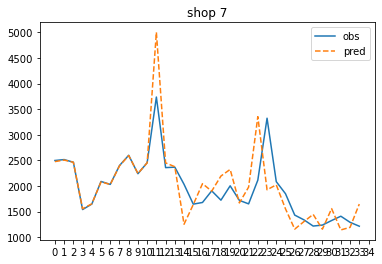

-----------------------shop 8.000000--------------------------
-----------------------shop 9.000000--------------------------
predicted=-5.228211, expected=3188.000000
Test MSE: 3193.228


-----------------------shop 10.000000--------------------------
predicted=574.835761, expected=428.000000
Test MSE: 146.836


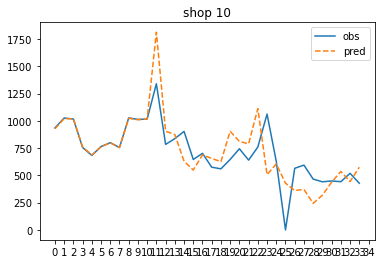

-----------------------shop 11.000000--------------------------
-----------------------shop 12.000000--------------------------
predicted=4445.588157, expected=2016.000000
Test MSE: 2429.588


-----------------------shop 13.000000--------------------------
-----------------------shop 14.000000--------------------------
predicted=1261.993437, expected=1007.000000
Test MSE: 254.993


-----------------------shop 15.000000--------------------------
predicted=1641.246806, expected=1248.000000
Test MSE: 393.247


-----------------------shop 16.000000--------------------------
predicted=1622.292430, expected=966.000000
Test MSE: 656.292


-----------------------shop 17.000000--------------------------
-----------------------shop 18.000000--------------------------
predicted=1293.944448, expected=1212.000000
Test MSE: 81.944


-----------------------shop 19.000000--------------------------
predicted=1576.471723, expected=1453.000000
Test MSE: 123.472


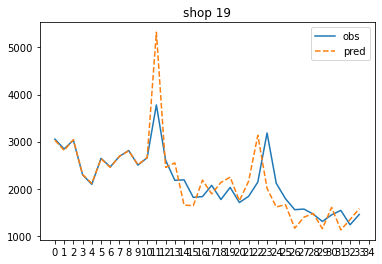

-----------------------shop 20.000000--------------------------
predicted=121.652248, expected=2611.000000
Test MSE: 2489.348


-----------------------shop 21.000000--------------------------
predicted=2311.063632, expected=1913.000000
Test MSE: 398.064


-----------------------shop 22.000000--------------------------
predicted=1445.778471, expected=1338.000000
Test MSE: 107.778


-----------------------shop 23.000000--------------------------
-----------------------shop 24.000000--------------------------
predicted=1443.202330, expected=1228.000000
Test MSE: 215.202


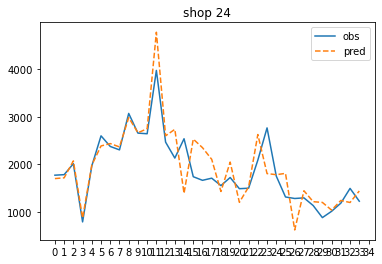

-----------------------shop 25.000000--------------------------
predicted=7043.067585, expected=6261.000000
Test MSE: 782.068


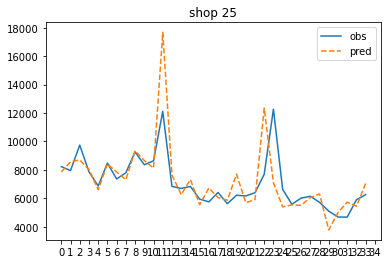

-----------------------shop 26.000000--------------------------
predicted=1396.204974, expected=1412.000000
Test MSE: 15.795


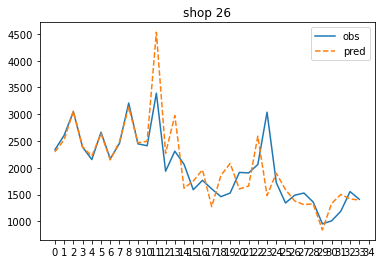

-----------------------shop 27.000000--------------------------
-----------------------shop 28.000000--------------------------
predicted=3582.060934, expected=3021.000000
Test MSE: 561.061


-----------------------shop 29.000000--------------------------
-----------------------shop 30.000000--------------------------
-----------------------shop 31.000000--------------------------
predicted=7829.027944, expected=6119.000000
Test MSE: 1710.028


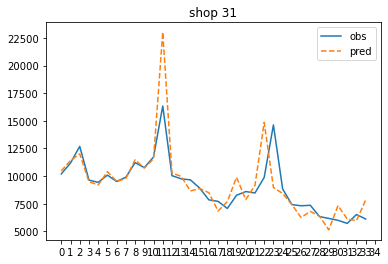

-----------------------shop 32.000000--------------------------
-----------------------shop 33.000000--------------------------
-----------------------shop 34.000000--------------------------
predicted=466.572186, expected=385.000000
Test MSE: 81.572


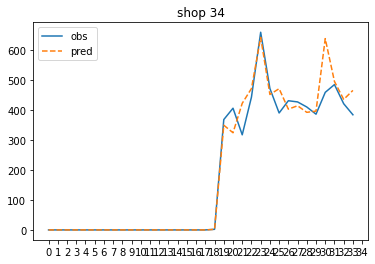

-----------------------shop 35.000000--------------------------
predicted=1946.885335, expected=1421.000000
Test MSE: 525.885


-----------------------shop 36.000000--------------------------
-----------------------shop 37.000000--------------------------
predicted=1600.729327, expected=833.000000
Test MSE: 767.729


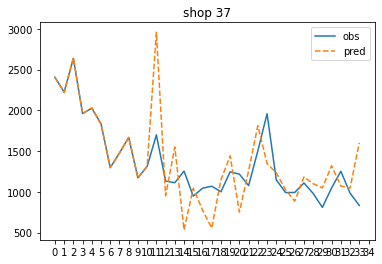

-----------------------shop 38.000000--------------------------
predicted=1537.121080, expected=1114.000000
Test MSE: 423.121


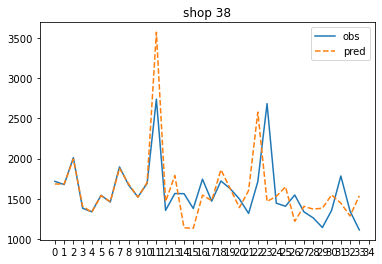

-----------------------shop 39.000000--------------------------
predicted=1067.526885, expected=998.000000
Test MSE: 69.527


-----------------------shop 40.000000--------------------------
-----------------------shop 41.000000--------------------------
predicted=776.107504, expected=743.000000
Test MSE: 33.108


-----------------------shop 42.000000--------------------------
predicted=5105.371940, expected=4498.000000
Test MSE: 607.372


-----------------------shop 43.000000--------------------------
-----------------------shop 44.000000--------------------------
predicted=950.992651, expected=780.000000
Test MSE: 170.993


-----------------------shop 45.000000--------------------------
predicted=700.311307, expected=702.000000
Test MSE: 1.689


-----------------------shop 46.000000--------------------------
predicted=1633.813524, expected=1322.000000
Test MSE: 311.814


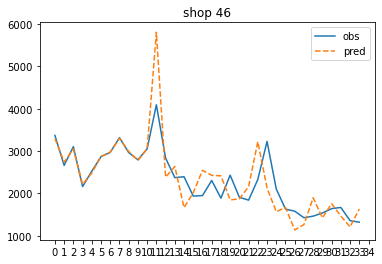

-----------------------shop 47.000000--------------------------
predicted=2437.733514, expected=1785.000000
Test MSE: 652.734


-----------------------shop 48.000000--------------------------
predicted=1257.220692, expected=1119.000000
Test MSE: 138.221


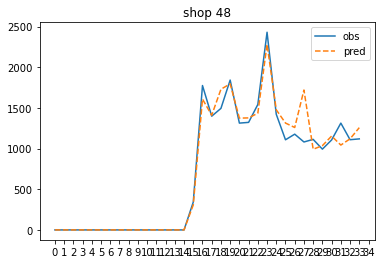

-----------------------shop 49.000000--------------------------
predicted=612.639638, expected=649.000000
Test MSE: 36.360


-----------------------shop 50.000000--------------------------
predicted=719.493322, expected=950.000000
Test MSE: 230.507


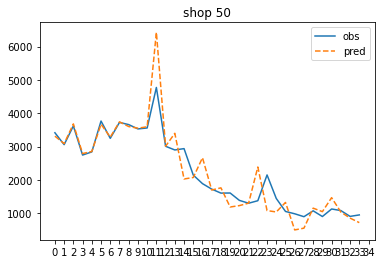

-----------------------shop 51.000000--------------------------
-----------------------shop 52.000000--------------------------
predicted=1039.667031, expected=852.000000
Test MSE: 187.667


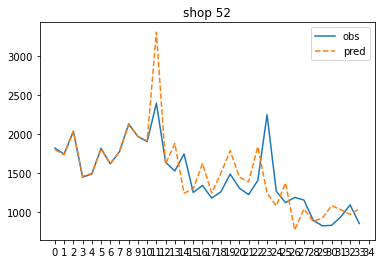

-----------------------shop 53.000000--------------------------
predicted=1342.096379, expected=1065.000000
Test MSE: 277.096


-----------------------shop 54.000000--------------------------
-----------------------shop 55.000000--------------------------
predicted=7078.798094, expected=1972.000000
Test MSE: 5106.798


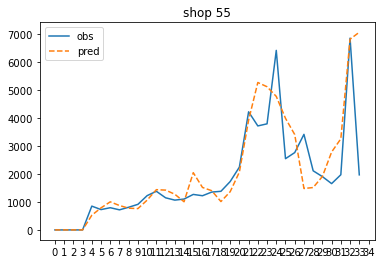

-----------------------shop 56.000000--------------------------
predicted=1077.423782, expected=1267.000000
Test MSE: 189.576


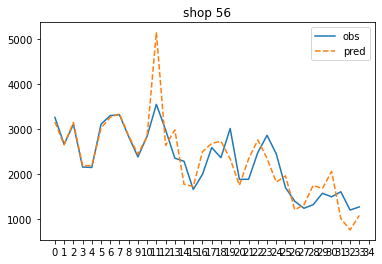

-----------------------shop 57.000000--------------------------
predicted=2024.864873, expected=2319.000000
Test MSE: 294.135


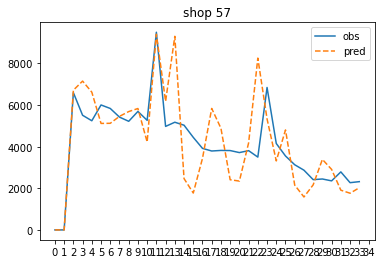

-----------------------shop 58.000000--------------------------
predicted=493.322543, expected=1448.000000
Test MSE: 954.677


-----------------------shop 59.000000--------------------------
predicted=1386.149541, expected=792.000000
Test MSE: 594.150


In [127]:
lista_pred_arima=[]
for i in ts_shop.columns.tolist():
    lista_pred_arima.append(train_evaluation_arima(ts_shop,i))

In [128]:
df_pred_arima=middleout_forecasting(lista_pred_arima,3)
df_pred_arima=submission_df(df_pred_arima)
df_pred_arima.rename(columns={'item_cnt_month_y':'pred'},inplace=True)

In [129]:
error_arima = evaluation(df_pred_arima)
print('Test MSE: %.3f' % error_arima)

Test MSE: 1.706


In [130]:
# 사리마 모델에 적용하여 실제 예측값 측정 
def forecast_arima_shops(ts,i):
    predictions = list()
    train=ts[i].values
    
    if (i in closed_shops or sum(train)==0):
        predictions.append(0)
    else:
        model = SARIMAX(train, order=(0,1,3), seasonal_order=(0,1,1,12))
        model_fit = model.fit()
        output = model_fit.predict(1, len(train)+1, typ='levels')
        yhat = output[-1]
        predictions.append(yhat)

        plt.plot(train,label='obs')
        plt.plot(output, label='pred',ls='--')
        plt.xticks(range(0,len(train)+1))
        plt.legend()
        plt.title('shop '+str(i))
        plt.show()
        
    predictions_series=pd.Series(predictions)
    return np.append(np.array(i),predictions_series.values.transpose())

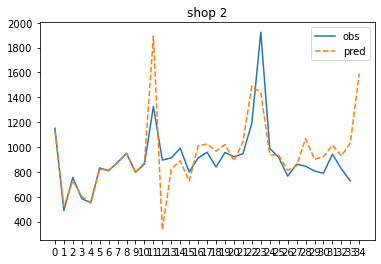

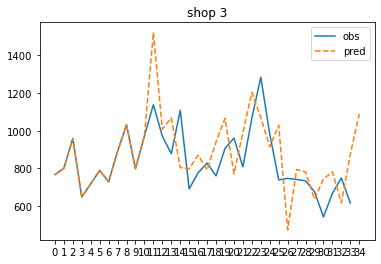

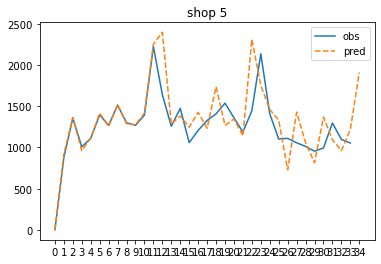

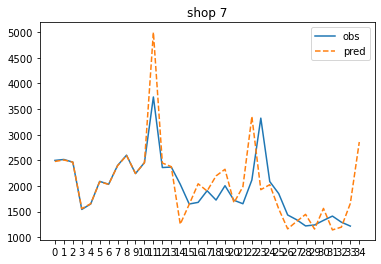

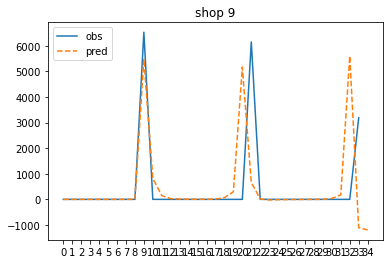

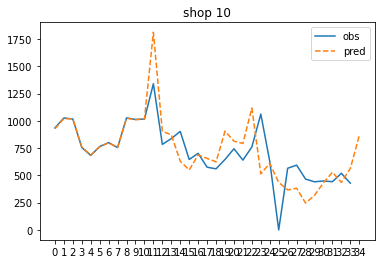

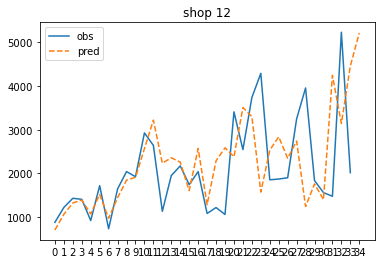

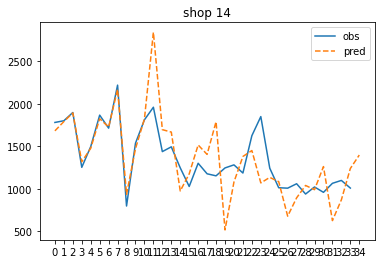

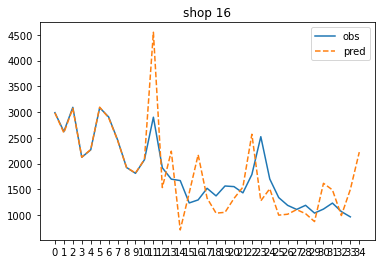

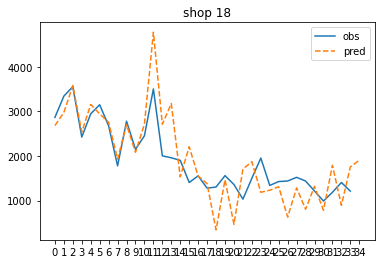

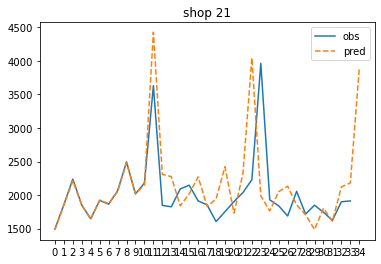

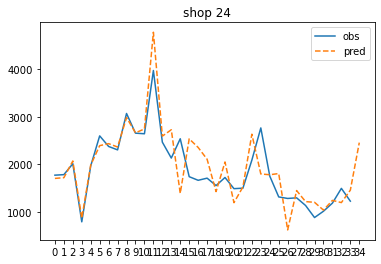

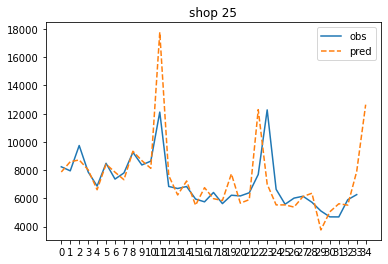

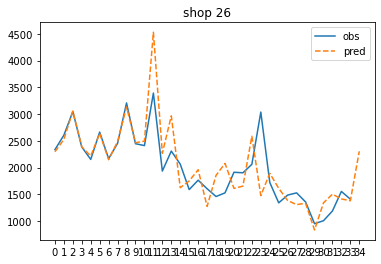

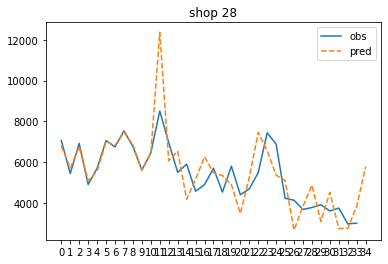

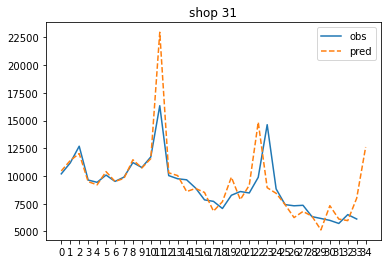

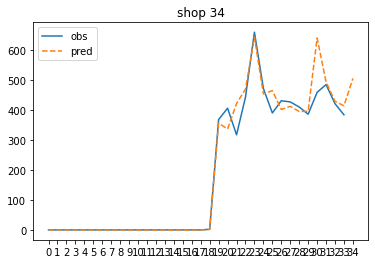

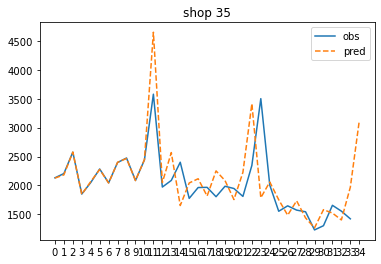

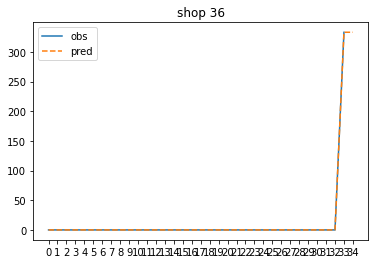

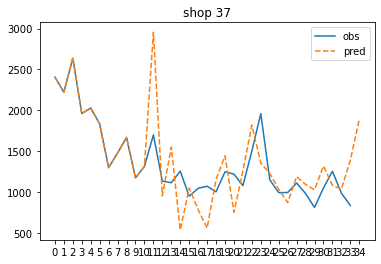

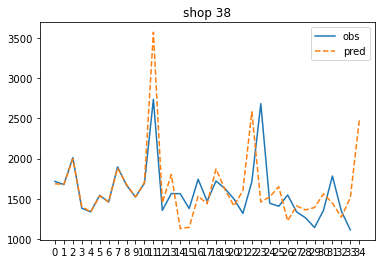

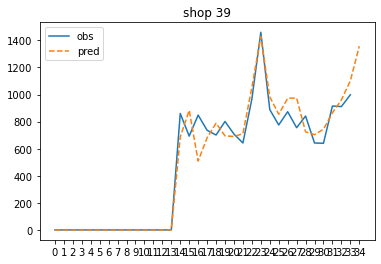

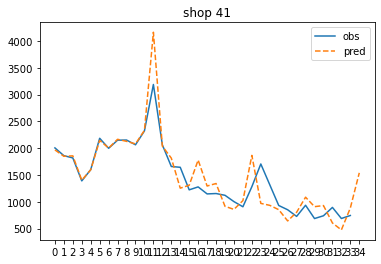

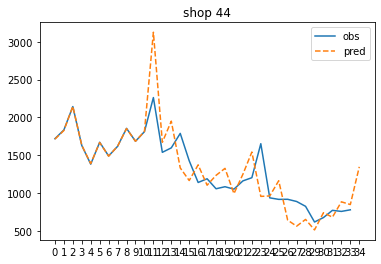

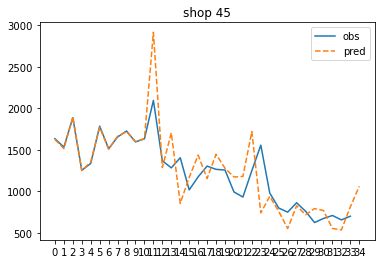

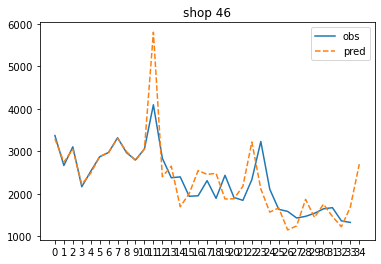

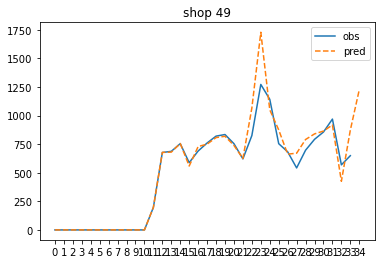

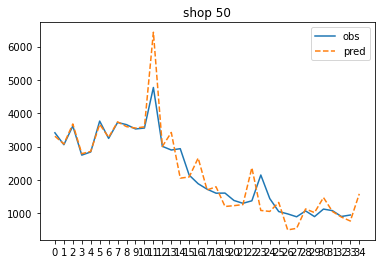

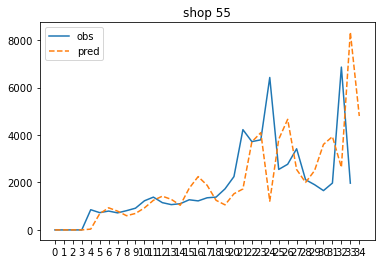

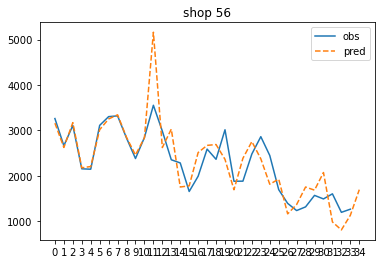

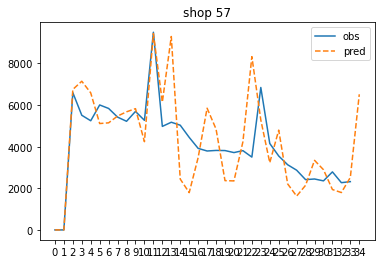

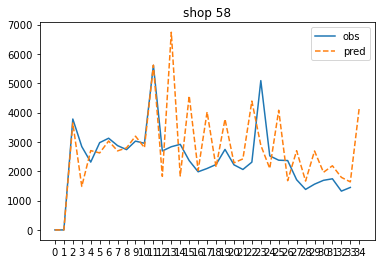

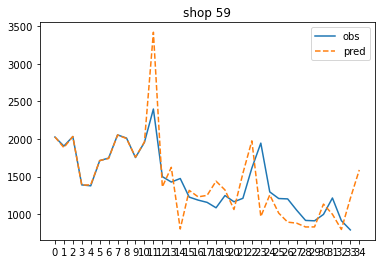

In [131]:
lista_pred_arima_test=[]
for i in ts_shop.columns.tolist():
    lista_pred_arima_test.append(forecast_arima_shops(ts_shop,i))

In [132]:
df_forecast_items=middleout_forecasting(lista_pred_arima_test,3)

In [133]:
# df_final=submission_df(df_forecast_items)
# df_final.to_csv('submission_arima_2.csv', index=False)